# DDPG implementation on Bipedalwalker

## 1. Import libraries

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


## 2. Classes for Critic and Actor networks

In [2]:
class CriticNetwork(keras.Model):
    def __init__(self, actionsNumber, fc1Dim, fc2Dim):
        # Initialise
        super(CriticNetwork, self).__init__()
        self.fc1Dim = fc1Dim
        self.fc2Dim = fc2Dim
        self.actionsNumber = actionsNumber
        
        # FC layers
        self.fc1 = Dense(self.fc1Dim, activation='relu')
        self.fc2 = Dense(self.fc2Dim, activation='relu')
        self.q = Dense(1, activation=None)

    def call(self, inputs):
        state, action = inputs
        action_value = self.fc1(tf.concat([state, action], axis=1))
        action_value = self.fc2(action_value)

        q = self.q(action_value)

        return q


class ActorNetwork(keras.Model):
    def __init__(self, actionsNumber, fc1Dim, fc2Dim):
        # Initialise
        super(ActorNetwork, self).__init__()
        self.fc1Dim = fc1Dim
        self.fc2Dim = fc2Dim
        self.actionsNumber = actionsNumber

        # FC layers
        self.fc1 = Dense(self.fc1Dim, activation='relu')
        self.fc2 = Dense(self.fc2Dim, activation='relu')
        self.mu = Dense(self.actionsNumber, activation='tanh')

    def call(self, state):
        prob = self.fc1(state)
        prob = self.fc2(prob)

        mu = self.mu(prob)

        return mu

## 3. Buffer Class

In [3]:
class ReplayBuffer():
    def __init__(self, maxSize, inputShape, actionsNumber):
        self.memorySize = maxSize
        self.memoryCounter = 0
        # Initialise replay buffer (s, a, r, s')
        self.stateBuffer = np.zeros((self.memorySize, *inputShape))
        self.actionBuffer = np.zeros((self.memorySize, actionsNumber))
        self.rewardBuffer = np.zeros(self.memorySize)
        self.newStateBuffer = np.zeros((self.memorySize, *inputShape))
        self.terminalBuffer = np.zeros(self.memorySize, dtype=np.bool_)

    def transition(self, state, action, reward, nextState, done):
        index = self.memoryCounter % self.memorySize
        self.stateBuffer[index] = state
        self.actionBuffer[index] = action
        self.rewardBuffer[index] = reward
        self.newStateBuffer[index] = nextState
        self.terminalBuffer[index] = done

        self.memoryCounter += 1
        return None

    def sample(self, batchSize):
        maxMemory = min(self.memoryCounter, self.memorySize)
        batchNumber = np.random.choice(maxMemory, batchSize)

        states = self.stateBuffer[batchNumber]
        actions = self.actionBuffer[batchNumber]
        rewards = self.rewardBuffer[batchNumber]
        nextStates = self.newStateBuffer[batchNumber]
        dones = self.terminalBuffer[batchNumber]

        return states, actions, rewards, nextStates, dones

## 4. Agent Class

In [4]:
class Agent:

    def __init__(self, inputShape=None, alpha=0.0001, beta=0.001, env=None, gamma=0.99, actionsNumber=2, maxSize=1000000, tau=0.001, fc1=400, fc2=300, batchSize=64, noise=0.1, checkpoint='model_checkpoint/ddpg/'):
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(maxSize, inputShape, actionsNumber)
        self.batchSize = batchSize
        self.actionsNumber = actionsNumber
        self.noise = noise
        self.maxAction = env.action_space.high[0]
        self.minAction = env.action_space.low[0]
        self.checkpoint = checkpoint

        # Initialise networks
        self.actor = ActorNetwork(actionsNumber=actionsNumber,fc1Dim=fc1, fc2Dim=fc2)
        self.critic = CriticNetwork(actionsNumber=actionsNumber, fc1Dim=fc1, fc2Dim=fc2)
        self.targetActor = ActorNetwork(actionsNumber=actionsNumber, fc1Dim=fc1, fc2Dim=fc2)
        self.targetCritic = CriticNetwork(actionsNumber=actionsNumber, fc1Dim=fc1, fc2Dim=fc2)

        # Compile networks
        self.actor.compile(optimizer=Adam(learning_rate=alpha))
        self.critic.compile(optimizer=Adam(learning_rate=beta))
        self.targetActor.compile(optimizer=Adam(learning_rate=alpha))
        self.targetCritic.compile(optimizer=Adam(learning_rate=beta))

        self.updateParameters(tau=1)

    def updateParameters(self, tau=None):
        if tau is None:
            tau = self.tau

        weights = []
        targets = self.targetActor.weights

        # Soft Copy 
        for i, weight in enumerate(self.actor.weights):
            weights.append(weight * tau + targets[i]*(1-tau))
        self.targetActor.set_weights(weights)

        weights = []
        targets = self.targetCritic.weights
        for i, weight in enumerate(self.critic.weights):
            weights.append(weight * tau + targets[i]*(1-tau))
        self.targetCritic.set_weights(weights)

    def transition(self, state, action, reward, nextState, done):
        self.memory.transition(state, action, reward, nextState, done)

    def save(self):
        print('')
        print('save models')
        self.actor.save(self.checkpoint+'actor')
        self.targetActor.save(self.checkpoint+'targetActor')
        self.critic.save(self.checkpoint+'critic')
        self.targetCritic.save(self.checkpoint+'targetCritic')

    def load(self):
        print('')
        print('load models')
        self.actor = keras.models.load_model(self.checkpoint+'actor')
        self.targetActor = keras.models.load_model(self.checkpoint+'targetActor')
        self.critic = keras.models.load_model(self.checkpoint+'critic')
        self.targetCritic = keras.models.load_model(self.checkpoint+'targetCritic')

    def chooseAction(self, observation, evaluate=False):
        state = tf.convert_to_tensor([observation], dtype=tf.float32)
        actions = self.actor(state)
        if not evaluate:
            # adding gussian noise to every action selection
            actions += tf.random.normal(shape=[self.actionsNumber], mean=0.0, stddev=self.noise)
        # max action when action is more than one
        actions = tf.clip_by_value(actions, self.minAction, self.maxAction)
        return actions[0]

    def learn(self):
        if self.memory.memoryCounter < self.batchSize:
            return None

        # Sampling state action reward and nextstate
        state, action, reward, nextState, done = self.memory.sample(self.batchSize)
        # Batches
        states = tf.convert_to_tensor(state, dtype=tf.float32)
        nextStates = tf.convert_to_tensor(nextState, dtype=tf.float32)
        rewards = tf.convert_to_tensor(reward, dtype=tf.float32)
        actions = tf.convert_to_tensor(action, dtype=tf.float32)
        # Gradient for critic network
        with tf.GradientTape() as tape:
            targetActions = self.targetActor(nextStates)
            nextCriticValue = tf.squeeze(self.targetCritic((nextStates, targetActions)), 1)
            criticValue = tf.squeeze(self.critic((states, actions)), 1)
            target = rewards + self.gamma*nextCriticValue*(1-done)
            criticLoss = keras.losses.MSE(target, criticValue)
        params = self.critic.trainable_variables
        gradients = tape.gradient(criticLoss, params)
        self.critic.optimizer.apply_gradients(zip(gradients, params))
        # Gradient for actor network
        with tf.GradientTape() as tape:
            newPolicyActions = self.actor(states)
            actorLoss = -self.critic((states, newPolicyActions))
            actorLoss = tf.math.reduce_mean(actorLoss)
        params = self.actor.trainable_variables
        gradients = tape.gradient(actorLoss, params)
        self.actor.optimizer.apply_gradients(zip(gradients, params))

        self.updateParameters()

## 5. Function for plotting learning curve

In [5]:
# def manage_memory():
#     gpus = tf.config.list_physical_devices('GPU')
#     if gpus:
#         try:
#             for gpu in gpus:
#                 tf.config.experimental.set_memory_growth(gpu, True)
#         except RuntimeError as e:
#             print(e)

def plot(x, scores, plotFile):
    avgScore = np.zeros(len(scores))
    for i in range(len(avgScore)):
        avgScore[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, avgScore)
    plt.title('Moving average of previous 100 scores')
    plt.savefig(plotFile)

## 6. Run


save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic\assets
episode 0 score -100.4 avg score -100.4
episode 1 score -127.6 avg score -114.0
episode 2 score -113.6 avg score -113.9
episode 3 score -105.8 avg score -111.8
episode 4 score -92.1 avg score -107.9
episode 5 score -125.7 avg score -110.8
episode 6 score -127.2 avg score -113.2
episode 7 score -122.3 avg score -114.3
episode 8 score -115.0 avg score -114.4
episode 9 score -199.5 avg score -122.9
episode 10 score -133.9 avg score -123.9
episode 11 score -145.9 avg score -125.7
episode 12 score -112.8 avg score -124.7
episode 13 score -123.2 avg score -124.6
episode 14 score -259.7 avg score -133.6
episode 15 score -107.9 avg score -132.0
episode 16 score -159.4 avg score -133.6
episode

episode 191 score -104.0 avg score -105.0
episode 192 score -103.1 avg score -105.0
episode 193 score -104.7 avg score -105.0
episode 194 score -102.5 avg score -105.0
episode 195 score -103.4 avg score -105.0
episode 196 score -103.9 avg score -105.1
episode 197 score -103.8 avg score -105.1
episode 198 score -106.4 avg score -105.1
episode 199 score -103.2 avg score -105.1
episode 200 score -112.3 avg score -105.2
episode 201 score -103.6 avg score -105.1
episode 202 score -104.5 avg score -105.0
episode 203 score -104.6 avg score -104.9
episode 204 score -102.6 avg score -104.9
episode 205 score -104.5 avg score -104.5
episode 206 score -103.0 avg score -104.4
episode 207 score -105.9 avg score -104.2
episode 208 score -104.0 avg score -104.2
episode 209 score -106.2 avg score -104.1
episode 210 score -103.0 avg score -104.0
episode 211 score -103.1 avg score -103.8
episode 212 score -113.7 avg score -102.6
episode 213 score -102.2 avg score -102.6
episode 214 score -108.7 avg score

episode 387 score -111.4 avg score -107.0
episode 388 score -104.4 avg score -107.0
episode 389 score -104.6 avg score -107.0
episode 390 score -109.7 avg score -107.1
episode 391 score -109.8 avg score -107.2
episode 392 score -111.3 avg score -107.2
episode 393 score -106.0 avg score -107.3
episode 394 score -112.0 avg score -107.4
episode 395 score -100.8 avg score -107.4
episode 396 score -101.9 avg score -107.3
episode 397 score -105.1 avg score -107.3
episode 398 score -109.3 avg score -107.4
episode 399 score -111.8 avg score -107.5
episode 400 score -112.1 avg score -107.5
episode 401 score -111.5 avg score -107.5
episode 402 score -109.6 avg score -107.6
episode 403 score -109.0 avg score -107.7
episode 404 score -104.2 avg score -107.6
episode 405 score -108.5 avg score -107.7
episode 406 score -103.3 avg score -107.6
episode 407 score -99.1 avg score -107.5
episode 408 score -101.0 avg score -107.4
episode 409 score -106.4 avg score -107.4
episode 410 score -105.6 avg score 

episode 583 score -114.4 avg score -133.5
episode 584 score -34.9 avg score -132.7
episode 585 score -127.6 avg score -133.0
episode 586 score -137.4 avg score -133.1
episode 587 score -82.3 avg score -132.8
episode 588 score -104.7 avg score -132.6
episode 589 score -111.6 avg score -132.7
episode 590 score -109.1 avg score -132.4
episode 591 score -103.5 avg score -132.2
episode 592 score -133.0 avg score -132.2
episode 593 score -121.2 avg score -132.3
episode 594 score -68.5 avg score -131.9
episode 595 score -130.4 avg score -132.0
episode 596 score -88.8 avg score -131.7
episode 597 score -143.5 avg score -132.0
episode 598 score -149.7 avg score -132.5
episode 599 score -106.0 avg score -132.6
episode 600 score -145.5 avg score -132.8
episode 601 score -102.1 avg score -132.4
episode 602 score -112.8 avg score -132.2
episode 603 score -129.6 avg score -132.0
episode 604 score -94.5 avg score -131.5
episode 605 score -112.0 avg score -131.3
episode 606 score -106.1 avg score -131

INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic\assets
episode 681 score -107.1 avg score -91.8

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic\assets
episode 682 score -71.3 avg score -91.2
episode 683 score -183.6 avg score -91.9
episode 684 score -113.9 avg score -92.7
episode 685 score -137.1 avg score -92.8
episode 686 score -31.6 avg score -91.7
episode 687 score -117.2 avg score -92.1
episode 688 score -94.2 avg score -92.0
episode 689 score -76.0 avg score -91.6
episode 690 score -123.8 avg score -91.8
episode 691 score -133.1 avg score -92.1
episode 692 score -100.6 avg score -91.8
episode 693 score -122.7 avg score -91.8
episode 694 scor

episode 744 score -79.9 avg score -88.3
episode 745 score 19.2 avg score -86.9
episode 746 score -101.8 avg score -86.9
episode 747 score -103.3 avg score -86.8
episode 748 score -62.6 avg score -86.4
episode 749 score -60.3 avg score -86.1
episode 750 score -104.8 avg score -85.9
episode 751 score -102.6 avg score -85.8
episode 752 score -102.2 avg score -85.6
episode 753 score -99.6 avg score -85.6
episode 754 score -79.0 avg score -85.1
episode 755 score -92.9 avg score -84.6
episode 756 score -69.8 avg score -85.7
episode 757 score -106.8 avg score -87.5
episode 758 score -69.3 avg score -87.8
episode 759 score -125.2 avg score -87.8
episode 760 score -111.4 avg score -88.9
episode 761 score -122.6 avg score -89.0
episode 762 score -110.7 avg score -89.5
episode 763 score -91.4 avg score -89.7
episode 764 score -89.0 avg score -89.6
episode 765 score -82.2 avg score -89.4
episode 766 score -108.3 avg score -89.6
episode 767 score -144.8 avg score -90.0
episode 768 score -135.2 avg 

episode 884 score 265.7 avg score -56.5

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic\assets
episode 885 score -14.8 avg score -55.4

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic\assets
episode 886 score 261.6 avg score -50.7

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic\assets
INFO:tensorflow:Assets written to: m

INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic\assets
episode 909 score 264.0 avg score 6.3

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic\assets
episode 910 score 271.7 avg score 9.7

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic\assets
episode 911 score 269.4 avg score 13.8

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor\assets
INFO:tensorflow:Assets written to: model

INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic\assets
episode 937 score -75.3 avg score 53.9

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic\assets
episode 938 score 75.3 avg score 56.1

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic\assets
episode 939 score 136.8 avg score 59.5

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor\assets
INFO:tensorflow:Assets written to:

episode 1072 score -112.5 avg score -19.8
episode 1073 score -116.6 avg score -23.6
episode 1074 score -116.7 avg score -23.7
episode 1075 score -128.1 avg score -25.3
episode 1076 score -125.7 avg score -25.5
episode 1077 score 272.5 avg score -21.7
episode 1078 score 45.8 avg score -20.2
episode 1079 score -53.0 avg score -20.0
episode 1080 score -13.0 avg score -19.1
episode 1081 score 254.9 avg score -15.8
episode 1082 score 253.9 avg score -12.9
episode 1083 score -51.7 avg score -12.4
episode 1084 score 88.5 avg score -11.3
episode 1085 score -45.0 avg score -11.3
episode 1086 score -26.5 avg score -11.0
episode 1087 score -13.5 avg score -10.7
episode 1088 score 55.5 avg score -9.2
episode 1089 score 40.7 avg score -8.2
episode 1090 score 155.1 avg score -6.0
episode 1091 score -105.9 avg score -8.0
episode 1092 score -111.2 avg score -9.0
episode 1093 score -56.2 avg score -9.9
episode 1094 score -39.3 avg score -9.2
episode 1095 score -66.9 avg score -11.0
episode 1096 score -

episode 1272 score -98.9 avg score -34.6
episode 1273 score -105.3 avg score -33.3
episode 1274 score 43.4 avg score -32.7
episode 1275 score 33.5 avg score -31.8
episode 1276 score -106.2 avg score -33.9
episode 1277 score 31.7 avg score -33.1
episode 1278 score 0.8 avg score -33.8
episode 1279 score -4.1 avg score -32.6
episode 1280 score 128.6 avg score -30.1
episode 1281 score 172.1 avg score -27.2
episode 1282 score 287.8 avg score -23.7
episode 1283 score -69.5 avg score -27.1
episode 1284 score -112.9 avg score -28.6
episode 1285 score 285.1 avg score -24.9
episode 1286 score -101.4 avg score -25.0
episode 1287 score -99.2 avg score -24.2
episode 1288 score -95.7 avg score -24.9
episode 1289 score -103.6 avg score -25.5
episode 1290 score -72.0 avg score -26.0
episode 1291 score -69.7 avg score -26.4
episode 1292 score 282.8 avg score -23.1
episode 1293 score 78.5 avg score -22.9
episode 1294 score -43.7 avg score -22.0
episode 1295 score 23.8 avg score -22.2
episode 1296 score 

episode 1446 score 65.6 avg score 27.2
episode 1447 score -113.7 avg score 23.3
episode 1448 score -59.7 avg score 23.0
episode 1449 score 16.2 avg score 23.8
episode 1450 score -113.1 avg score 19.8
episode 1451 score 64.6 avg score 19.3
episode 1452 score -43.3 avg score 19.5
episode 1453 score -116.4 avg score 17.8
episode 1454 score 113.3 avg score 16.1
episode 1455 score 98.9 avg score 16.5
episode 1456 score 66.6 avg score 16.5
episode 1457 score -26.6 avg score 15.0
episode 1458 score 283.5 avg score 17.3
episode 1459 score 283.8 avg score 17.4
episode 1460 score 50.2 avg score 16.5
episode 1461 score 154.2 avg score 15.2
episode 1462 score 9.3 avg score 15.3
episode 1463 score -46.5 avg score 12.2
episode 1464 score -34.6 avg score 9.2
episode 1465 score -55.2 avg score 5.8
episode 1466 score -36.8 avg score 2.6
episode 1467 score -0.5 avg score -0.2
episode 1468 score -2.7 avg score -1.3
episode 1469 score -35.6 avg score -4.4
episode 1470 score -76.4 avg score -8.1
episode 14

episode 1649 score 39.4 avg score -26.8
episode 1650 score -144.4 avg score -28.0
episode 1651 score -97.3 avg score -28.8
episode 1652 score -5.3 avg score -31.6
episode 1653 score -94.7 avg score -32.6
episode 1654 score -131.9 avg score -33.4
episode 1655 score -135.0 avg score -33.9
episode 1656 score 36.2 avg score -34.2
episode 1657 score -140.6 avg score -34.6
episode 1658 score -140.5 avg score -36.2
episode 1659 score -133.3 avg score -37.5
episode 1660 score -61.1 avg score -37.1
episode 1661 score -138.8 avg score -37.5
episode 1662 score -136.3 avg score -37.7
episode 1663 score -144.2 avg score -38.8
episode 1664 score 258.5 avg score -35.4
episode 1665 score 254.0 avg score -35.6
episode 1666 score -158.7 avg score -36.2
episode 1667 score -26.1 avg score -36.4
episode 1668 score -18.5 avg score -39.4
episode 1669 score 30.8 avg score -38.9
episode 1670 score -127.3 avg score -40.9
episode 1671 score 20.6 avg score -41.6
episode 1672 score 120.0 avg score -41.4
episode 16

episode 1851 score -75.1 avg score -65.2
episode 1852 score -99.7 avg score -65.3
episode 1853 score -58.9 avg score -64.3
episode 1854 score -67.9 avg score -65.1
episode 1855 score -58.0 avg score -64.3
episode 1856 score -94.3 avg score -64.7
episode 1857 score 243.1 avg score -60.8
episode 1858 score -59.0 avg score -60.4
episode 1859 score -90.2 avg score -60.3
episode 1860 score -88.5 avg score -60.2
episode 1861 score -9.1 avg score -59.6
episode 1862 score -28.8 avg score -58.8
episode 1863 score -98.7 avg score -58.8
episode 1864 score 48.6 avg score -57.3
episode 1865 score 139.2 avg score -55.6
episode 1866 score -35.8 avg score -54.9
episode 1867 score -62.5 avg score -54.5
episode 1868 score -59.7 avg score -54.2
episode 1869 score 9.3 avg score -53.0
episode 1870 score 62.0 avg score -51.5
episode 1871 score -27.9 avg score -50.7
episode 1872 score -69.5 avg score -50.5
episode 1873 score 257.9 avg score -48.0
episode 1874 score 269.7 avg score -44.3
episode 1875 score 99

episode 2056 score 2.3 avg score 47.9
episode 2057 score -83.0 avg score 48.1
episode 2058 score 108.5 avg score 49.0
episode 2059 score -67.6 avg score 47.7
episode 2060 score -65.7 avg score 46.3
episode 2061 score -77.8 avg score 45.0
episode 2062 score -0.2 avg score 43.8
episode 2063 score -108.0 avg score 41.9
episode 2064 score -108.5 avg score 40.5
episode 2065 score 10.4 avg score 41.4
episode 2066 score -97.2 avg score 40.8
episode 2067 score -113.2 avg score 40.5
episode 2068 score -93.8 avg score 40.5
episode 2069 score 34.2 avg score 41.8
episode 2070 score -101.6 avg score 41.1
episode 2071 score -104.3 avg score 41.1
episode 2072 score -112.4 avg score 40.7
episode 2073 score -96.9 avg score 39.1
episode 2074 score 2.7 avg score 39.7
episode 2075 score -57.1 avg score 40.1
episode 2076 score -48.1 avg score 36.7
episode 2077 score -39.2 avg score 36.4
episode 2078 score -51.4 avg score 36.2
episode 2079 score 2.2 avg score 37.2
episode 2080 score 13.4 avg score 38.2
epis

episode 2214 score -158.2 avg score -49.8
episode 2215 score -154.5 avg score -54.2
episode 2216 score -173.0 avg score -56.3
episode 2217 score -159.3 avg score -60.8
episode 2218 score -214.2 avg score -65.8
episode 2219 score -188.7 avg score -66.9
episode 2220 score -169.0 avg score -71.5
episode 2221 score -185.0 avg score -72.9
episode 2222 score -120.7 avg score -77.1
episode 2223 score -119.7 avg score -77.7
episode 2224 score -107.4 avg score -81.8
episode 2225 score -89.8 avg score -85.6
episode 2226 score -85.6 avg score -86.5
episode 2227 score -91.4 avg score -88.1
episode 2228 score -106.0 avg score -88.2
episode 2229 score -134.1 avg score -90.6
episode 2230 score -167.4 avg score -91.2
episode 2231 score -167.0 avg score -91.9
episode 2232 score -163.0 avg score -92.6
episode 2233 score -173.0 avg score -93.5
episode 2234 score -165.8 avg score -96.4
episode 2235 score -176.7 avg score -97.1
episode 2236 score -85.3 avg score -98.6
episode 2237 score -164.9 avg score -1

episode 2407 score -114.4 avg score -71.9
episode 2408 score -72.0 avg score -71.4
episode 2409 score -17.6 avg score -70.4
episode 2410 score -29.1 avg score -69.6
episode 2411 score 64.4 avg score -67.7
episode 2412 score -21.1 avg score -66.7
episode 2413 score -109.2 avg score -66.2
episode 2414 score -100.2 avg score -66.0
episode 2415 score 4.3 avg score -64.5
episode 2416 score -91.5 avg score -64.3
episode 2417 score -91.9 avg score -64.0
episode 2418 score -23.7 avg score -63.0
episode 2419 score -99.2 avg score -62.8
episode 2420 score -85.0 avg score -62.5
episode 2421 score -90.5 avg score -62.3
episode 2422 score -54.4 avg score -61.7
episode 2423 score -23.2 avg score -60.7
episode 2424 score -74.8 avg score -60.3
episode 2425 score -102.9 avg score -60.2
episode 2426 score -66.5 avg score -59.4
episode 2427 score 17.0 avg score -58.0
episode 2428 score -87.5 avg score -57.8
episode 2429 score -65.8 avg score -57.2
episode 2430 score -125.7 avg score -57.2
episode 2431 sc

episode 2609 score 123.5 avg score 32.5
episode 2610 score -7.5 avg score 31.9
episode 2611 score 9.5 avg score 32.8
episode 2612 score 165.0 avg score 34.3
episode 2613 score -27.4 avg score 34.1
episode 2614 score 293.1 avg score 37.8
episode 2615 score 292.4 avg score 41.8
episode 2616 score 294.3 avg score 44.3
episode 2617 score 296.3 avg score 47.0
episode 2618 score 293.0 avg score 50.4
episode 2619 score 289.7 avg score 52.0
episode 2620 score 291.1 avg score 55.3
episode 2621 score 292.4 avg score 57.2
episode 2622 score 294.6 avg score 59.1
episode 2623 score 292.0 avg score 62.4
episode 2624 score 102.8 avg score 62.2
episode 2625 score -40.7 avg score 62.5
episode 2626 score -9.0 avg score 59.6
episode 2627 score -7.2 avg score 59.5
episode 2628 score 288.3 avg score 60.9
episode 2629 score 287.0 avg score 64.6
episode 2630 score 291.7 avg score 67.8
episode 2631 score 290.3 avg score 67.8
episode 2632 score 291.9 avg score 71.2
episode 2633 score 293.6 avg score 73.6
episo

INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic\assets
episode 2659 score 175.0 avg score 135.4

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic\assets
episode 2660 score 281.8 avg score 139.3

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic\assets
episode 2661 score 288.7 avg score 141.8
episode 2662 score 3.0 avg score 141.7


episode 2765 score -98.6 avg score 26.6
episode 2766 score 51.0 avg score 27.4
episode 2767 score 272.2 avg score 27.2
episode 2768 score -134.8 avg score 24.6
episode 2769 score -132.2 avg score 23.1
episode 2770 score -84.8 avg score 22.9
episode 2771 score -53.2 avg score 22.1
episode 2772 score -107.0 avg score 19.9
episode 2773 score -52.9 avg score 20.1
episode 2774 score -120.5 avg score 16.0
episode 2775 score -72.1 avg score 12.4
episode 2776 score -75.4 avg score 10.0
episode 2777 score 161.1 avg score 8.8
episode 2778 score -99.4 avg score 7.4
episode 2779 score -109.4 avg score 3.4
episode 2780 score -98.9 avg score -0.5
episode 2781 score -96.2 avg score -2.2
episode 2782 score -144.6 avg score -2.7
episode 2783 score -139.3 avg score -3.7
episode 2784 score -152.1 avg score -4.4
episode 2785 score -158.2 avg score -5.7
episode 2786 score -113.9 avg score -6.7
episode 2787 score -135.1 avg score -11.0
episode 2788 score -131.2 avg score -11.3
episode 2789 score -158.1 avg 

episode 2959 score -138.8 avg score -137.2
episode 2960 score -132.6 avg score -137.3
episode 2961 score -143.1 avg score -137.5
episode 2962 score -132.3 avg score -137.4
episode 2963 score -89.7 avg score -137.2
episode 2964 score -175.8 avg score -137.5
episode 2965 score -177.9 avg score -137.5
episode 2966 score -131.9 avg score -137.3
episode 2967 score -176.2 avg score -137.6
episode 2968 score -128.9 avg score -137.1
episode 2969 score -138.5 avg score -137.1
episode 2970 score -155.8 avg score -137.0
episode 2971 score -186.8 avg score -137.4
episode 2972 score -171.2 avg score -137.6
episode 2973 score -167.5 avg score -137.8
episode 2974 score -169.0 avg score -138.0
episode 2975 score -170.0 avg score -138.3
episode 2976 score -156.8 avg score -138.7
episode 2977 score -102.4 avg score -138.4
episode 2978 score -122.5 avg score -138.4
episode 2979 score -142.0 avg score -138.4
episode 2980 score -134.6 avg score -137.2
episode 2981 score -65.6 avg score -136.3
episode 2982 

episode 3157 score 175.4 avg score 99.3
episode 3158 score 290.4 avg score 102.9
episode 3159 score 166.9 avg score 106.0
episode 3160 score -102.1 avg score 106.3
episode 3161 score -179.3 avg score 104.8
episode 3162 score 77.4 avg score 105.3
episode 3163 score 48.5 avg score 106.3
episode 3164 score -51.7 avg score 107.3
episode 3165 score -25.5 avg score 104.2
episode 3166 score 11.2 avg score 101.5
episode 3167 score -52.4 avg score 98.2
episode 3168 score -48.0 avg score 99.0
episode 3169 score 78.0 avg score 100.5
episode 3170 score -96.2 avg score 99.6
episode 3171 score 292.2 avg score 99.8
episode 3172 score -101.4 avg score 97.8
episode 3173 score 290.2 avg score 98.0
episode 3174 score -91.4 avg score 95.9
episode 3175 score -27.1 avg score 92.9
episode 3176 score -13.2 avg score 90.0
episode 3177 score 288.8 avg score 90.2
episode 3178 score 289.3 avg score 90.3
episode 3179 score 290.5 avg score 90.4
episode 3180 score -59.5 avg score 88.8
episode 3181 score 289.7 avg sc

episode 3360 score -53.0 avg score -62.0
episode 3361 score -109.5 avg score -62.6
episode 3362 score -97.2 avg score -62.8
episode 3363 score -109.7 avg score -63.4
episode 3364 score -71.8 avg score -63.1
episode 3365 score -107.1 avg score -63.7
episode 3366 score -103.0 avg score -64.2
episode 3367 score -20.5 avg score -64.2
episode 3368 score 58.4 avg score -62.7
episode 3369 score 277.2 avg score -59.1
episode 3370 score 252.4 avg score -56.6
episode 3371 score -13.8 avg score -55.8
episode 3372 score -95.2 avg score -56.0
episode 3373 score -68.1 avg score -57.6
episode 3374 score -44.4 avg score -57.1
episode 3375 score -114.0 avg score -58.9
episode 3376 score -142.1 avg score -59.4
episode 3377 score -109.8 avg score -59.8
episode 3378 score 200.2 avg score -57.0
episode 3379 score -93.8 avg score -57.0
episode 3380 score -142.0 avg score -59.2
episode 3381 score -74.7 avg score -59.4
episode 3382 score -84.6 avg score -59.4
episode 3383 score -21.1 avg score -58.5
episode 3

episode 3560 score 80.5 avg score -75.0
episode 3561 score 161.6 avg score -72.7
episode 3562 score -45.5 avg score -72.4
episode 3563 score -6.2 avg score -71.6
episode 3564 score -37.3 avg score -71.0
episode 3565 score -53.4 avg score -71.2
episode 3566 score 3.1 avg score -69.9
episode 3567 score 20.1 avg score -68.9
episode 3568 score -3.9 avg score -68.2
episode 3569 score -87.5 avg score -68.6
episode 3570 score -104.4 avg score -68.6
episode 3571 score 5.0 avg score -67.6
episode 3572 score -55.8 avg score -67.4
episode 3573 score -56.9 avg score -67.2
episode 3574 score -60.3 avg score -66.4
episode 3575 score -96.2 avg score -66.0
episode 3576 score 296.8 avg score -62.2
episode 3577 score -63.4 avg score -62.0
episode 3578 score -39.9 avg score -61.6
episode 3579 score -42.1 avg score -61.2
episode 3580 score 106.5 avg score -59.2
episode 3581 score -38.8 avg score -58.8
episode 3582 score 288.7 avg score -54.9
episode 3583 score -31.2 avg score -54.7
episode 3584 score -51.

episode 3765 score -60.5 avg score 12.7
episode 3766 score 1.1 avg score 9.8
episode 3767 score -48.5 avg score 6.9
episode 3768 score -95.6 avg score 7.1
episode 3769 score -77.5 avg score 3.6
episode 3770 score -52.7 avg score 1.6
episode 3771 score -63.5 avg score -1.5
episode 3772 score -47.8 avg score -0.9
episode 3773 score -26.0 avg score -3.5
episode 3774 score -46.5 avg score -6.7
episode 3775 score -68.3 avg score -10.1
episode 3776 score -78.6 avg score -13.6
episode 3777 score -6.1 avg score -16.4
episode 3778 score -62.9 avg score -18.2
episode 3779 score -58.3 avg score -21.5
episode 3780 score -75.8 avg score -21.4
episode 3781 score -77.3 avg score -22.5
episode 3782 score -48.2 avg score -23.1
episode 3783 score -14.7 avg score -23.0
episode 3784 score -5.6 avg score -22.1
episode 3785 score 8.2 avg score -21.5
episode 3786 score -75.7 avg score -21.9
episode 3787 score -67.0 avg score -22.1
episode 3788 score -29.2 avg score -22.2
episode 3789 score -107.4 avg score -

episode 3968 score 290.9 avg score 10.1
episode 3969 score 98.4 avg score 11.2
episode 3970 score 172.7 avg score 12.8
episode 3971 score -29.5 avg score 12.5
episode 3972 score -106.4 avg score 12.0
episode 3973 score -29.8 avg score 12.5
episode 3974 score -24.3 avg score 12.8
episode 3975 score -54.4 avg score 13.0
episode 3976 score -39.4 avg score 12.8
episode 3977 score -92.1 avg score 12.6
episode 3978 score 31.0 avg score 13.4
episode 3979 score 39.9 avg score 13.5
episode 3980 score -112.5 avg score 13.0
episode 3981 score 71.8 avg score 14.7
episode 3982 score -108.6 avg score 14.2
episode 3983 score -46.1 avg score 14.0
episode 3984 score -26.3 avg score 14.3
episode 3985 score 296.3 avg score 17.9
episode 3986 score -65.9 avg score 18.2
episode 3987 score 34.7 avg score 19.1
episode 3988 score -107.2 avg score 18.8
episode 3989 score -93.5 avg score 19.0
episode 3990 score -14.7 avg score 18.9
episode 3991 score 17.2 avg score 20.1
episode 3992 score -50.2 avg score 20.4
ep

episode 4172 score 293.6 avg score 115.0
episode 4173 score -45.5 avg score 111.6
episode 4174 score 290.3 avg score 114.8
episode 4175 score -119.6 avg score 112.6
episode 4176 score -30.5 avg score 112.3
episode 4177 score 8.3 avg score 109.4
episode 4178 score -131.6 avg score 105.2
episode 4179 score 20.6 avg score 102.5
episode 4180 score 19.0 avg score 99.8
episode 4181 score -130.8 avg score 98.5
episode 4182 score -106.5 avg score 96.5
episode 4183 score 76.2 avg score 96.2
episode 4184 score -137.0 avg score 94.6
episode 4185 score -136.4 avg score 92.7
episode 4186 score -9.8 avg score 89.7
episode 4187 score -2.0 avg score 88.8
episode 4188 score -75.7 avg score 85.1
episode 4189 score -95.4 avg score 83.4
episode 4190 score 79.1 avg score 83.0
episode 4191 score 15.1 avg score 81.7
episode 4192 score -101.2 avg score 80.3
episode 4193 score 102.3 avg score 81.0
episode 4194 score 57.2 avg score 81.3
episode 4195 score 14.3 avg score 81.5
episode 4196 score 288.8 avg score 8

episode 4377 score -100.4 avg score 87.6
episode 4378 score -91.2 avg score 85.3
episode 4379 score -13.0 avg score 82.3
episode 4380 score -149.1 avg score 81.3
episode 4381 score -78.6 avg score 77.6
episode 4382 score -116.9 avg score 76.7
episode 4383 score 24.6 avg score 77.3
episode 4384 score 26.1 avg score 78.6
episode 4385 score 221.5 avg score 81.1
episode 4386 score -106.9 avg score 80.5
episode 4387 score 233.3 avg score 83.4
episode 4388 score 262.9 avg score 86.2
episode 4389 score -138.5 avg score 85.7
episode 4390 score 262.9 avg score 85.5
episode 4391 score 247.2 avg score 89.0
episode 4392 score 272.1 avg score 91.4
episode 4393 score 282.7 avg score 91.3
episode 4394 score 270.6 avg score 91.0
episode 4395 score 268.5 avg score 93.1
episode 4396 score 269.5 avg score 92.8
episode 4397 score -139.4 avg score 90.2
episode 4398 score 270.4 avg score 93.1
episode 4399 score 269.4 avg score 92.8
episode 4400 score 273.3 avg score 96.6
episode 4401 score 263.0 avg score 9

episode 4582 score 6.7 avg score 79.1
episode 4583 score 149.6 avg score 81.2
episode 4584 score 284.3 avg score 84.3
episode 4585 score 280.6 avg score 86.5
episode 4586 score 272.2 avg score 86.4
episode 4587 score 143.1 avg score 85.0
episode 4588 score 80.4 avg score 85.9
episode 4589 score 286.2 avg score 89.1
episode 4590 score 84.6 avg score 89.9
episode 4591 score -83.7 avg score 87.5
episode 4592 score -111.8 avg score 84.7
episode 4593 score -94.0 avg score 80.9
episode 4594 score -41.9 avg score 80.0
episode 4595 score -57.5 avg score 78.0
episode 4596 score -103.5 avg score 77.5
episode 4597 score 124.3 avg score 79.1
episode 4598 score 13.5 avg score 78.7
episode 4599 score 280.8 avg score 81.3
episode 4600 score 18.6 avg score 82.2
episode 4601 score 286.2 avg score 85.5
episode 4602 score 282.8 avg score 89.4
episode 4603 score -127.1 avg score 88.3
episode 4604 score -161.3 avg score 86.6
episode 4605 score -141.6 avg score 86.0
episode 4606 score 44.8 avg score 86.0
ep

episode 4788 score -51.0 avg score 51.5
episode 4789 score 10.5 avg score 50.4
episode 4790 score 291.9 avg score 50.5
episode 4791 score 68.7 avg score 50.5
episode 4792 score -53.0 avg score 47.2
episode 4793 score -50.5 avg score 45.6
episode 4794 score -48.0 avg score 42.2
episode 4795 score 130.2 avg score 40.7
episode 4796 score 119.2 avg score 38.9
episode 4797 score -17.9 avg score 35.8
episode 4798 score -30.4 avg score 32.6
episode 4799 score -26.6 avg score 33.1
episode 4800 score -8.8 avg score 33.5
episode 4801 score -86.1 avg score 31.1
episode 4802 score -49.2 avg score 29.7
episode 4803 score 287.5 avg score 31.1
episode 4804 score 56.0 avg score 31.6
episode 4805 score -74.9 avg score 28.0
episode 4806 score -42.5 avg score 27.1
episode 4807 score 68.5 avg score 28.6
episode 4808 score 28.2 avg score 26.1
episode 4809 score 11.9 avg score 26.8
episode 4810 score 287.1 avg score 29.3
episode 4811 score 70.3 avg score 27.2
episode 4812 score -25.9 avg score 24.1
episode 

episode 4995 score -66.9 avg score 49.7
episode 4996 score 287.7 avg score 52.0
episode 4997 score 132.0 avg score 50.5
episode 4998 score 64.5 avg score 52.2
episode 4999 score -68.5 avg score 51.2
episode 5000 score -102.6 avg score 47.3
episode 5001 score 85.9 avg score 47.3
episode 5002 score 80.9 avg score 45.2
episode 5003 score 33.4 avg score 45.0
episode 5004 score -15.2 avg score 43.5
episode 5005 score -68.4 avg score 42.7
episode 5006 score -22.5 avg score 41.9
episode 5007 score 38.1 avg score 43.2
episode 5008 score -61.6 avg score 42.5
episode 5009 score 41.3 avg score 43.8
episode 5010 score -49.6 avg score 44.2
episode 5011 score -40.9 avg score 40.9
episode 5012 score -58.6 avg score 37.5
episode 5013 score -22.0 avg score 36.2
episode 5014 score 42.6 avg score 36.0
episode 5015 score -39.2 avg score 35.6
episode 5016 score -49.4 avg score 32.2
episode 5017 score -53.0 avg score 31.5
episode 5018 score -88.1 avg score 29.9
episode 5019 score -91.4 avg score 28.9
episod

episode 5199 score 14.9 avg score 128.0
episode 5200 score 278.9 avg score 128.0
episode 5201 score 286.1 avg score 128.0
episode 5202 score -61.9 avg score 124.7
episode 5203 score -75.3 avg score 121.1
episode 5204 score 283.8 avg score 121.1
episode 5205 score -67.1 avg score 117.5
episode 5206 score 147.4 avg score 120.0
episode 5207 score -51.4 avg score 116.7
episode 5208 score 286.0 avg score 116.7
episode 5209 score -60.2 avg score 116.3
episode 5210 score -58.5 avg score 115.1
episode 5211 score -31.4 avg score 111.9
episode 5212 score -83.1 avg score 108.2
episode 5213 score -29.4 avg score 105.0
episode 5214 score -73.9 avg score 101.4
episode 5215 score -73.5 avg score 97.8
episode 5216 score -3.8 avg score 97.9
episode 5217 score -58.9 avg score 97.7
episode 5218 score -37.0 avg score 94.5
episode 5219 score -63.1 avg score 94.9
episode 5220 score 287.6 avg score 95.0
episode 5221 score 156.2 avg score 93.7
episode 5222 score 118.3 avg score 95.2
episode 5223 score 40.6 av

episode 5405 score 291.1 avg score 90.2
episode 5406 score 292.3 avg score 93.2
episode 5407 score -56.4 avg score 93.7
episode 5408 score -106.5 avg score 93.8
episode 5409 score 287.7 avg score 96.3
episode 5410 score 286.8 avg score 99.6
episode 5411 score 281.5 avg score 99.6
episode 5412 score 288.5 avg score 102.4
episode 5413 score 287.8 avg score 105.2
episode 5414 score -52.6 avg score 104.8
episode 5415 score 164.2 avg score 103.6
episode 5416 score 10.9 avg score 102.1
episode 5417 score -94.8 avg score 100.9
episode 5418 score 18.0 avg score 102.2
episode 5419 score 290.4 avg score 104.8
episode 5420 score -92.9 avg score 103.9
episode 5421 score 284.0 avg score 107.4
episode 5422 score 282.7 avg score 109.7
episode 5423 score 285.2 avg score 109.7
episode 5424 score -56.1 avg score 108.4
episode 5425 score 90.8 avg score 106.5
episode 5426 score 289.6 avg score 109.6
episode 5427 score 284.6 avg score 111.8
episode 5428 score 269.3 avg score 114.5
episode 5429 score 274.9 

episode 5607 score -15.2 avg score 92.9
episode 5608 score 284.2 avg score 95.1
episode 5609 score -107.6 avg score 91.1
episode 5610 score -111.8 avg score 88.9
episode 5611 score -110.1 avg score 87.9
episode 5612 score 287.9 avg score 91.8
episode 5613 score 5.0 avg score 91.5
episode 5614 score 288.8 avg score 91.5
episode 5615 score -100.2 avg score 91.0
episode 5616 score -88.2 avg score 90.7
episode 5617 score -105.7 avg score 86.7
episode 5618 score -114.3 avg score 85.9
episode 5619 score -113.8 avg score 81.8
episode 5620 score 43.4 avg score 79.3
episode 5621 score -117.5 avg score 77.7
episode 5622 score 87.9 avg score 78.2
episode 5623 score 24.0 avg score 77.4
episode 5624 score 286.4 avg score 77.3
episode 5625 score 122.8 avg score 79.3
episode 5626 score 53.3 avg score 76.8
episode 5627 score 89.6 avg score 74.8
episode 5628 score 148.0 avg score 76.4
episode 5629 score -108.7 avg score 75.1
episode 5630 score 281.4 avg score 75.0
episode 5631 score 285.9 avg score 76.

episode 5811 score -80.8 avg score -28.2
episode 5812 score -85.6 avg score -30.0
episode 5813 score -23.7 avg score -30.0
episode 5814 score -15.5 avg score -31.1
episode 5815 score -46.6 avg score -34.5
episode 5816 score -76.4 avg score -38.2
episode 5817 score -69.9 avg score -37.7
episode 5818 score -173.8 avg score -42.4
episode 5819 score -88.9 avg score -46.1
episode 5820 score -96.7 avg score -49.9
episode 5821 score -88.9 avg score -50.7
episode 5822 score -97.3 avg score -51.5
episode 5823 score -78.4 avg score -51.4
episode 5824 score -100.6 avg score -54.1
episode 5825 score -93.5 avg score -55.1
episode 5826 score -91.0 avg score -55.6
episode 5827 score -92.0 avg score -59.4
episode 5828 score -96.0 avg score -60.0
episode 5829 score -96.5 avg score -61.5
episode 5830 score -86.1 avg score -63.1
episode 5831 score -84.4 avg score -66.8
episode 5832 score -99.0 avg score -68.1
episode 5833 score -21.6 avg score -71.2
episode 5834 score -46.1 avg score -71.2
episode 5835 s

episode 6016 score 8.9 avg score 53.3
episode 6017 score -61.6 avg score 53.9
episode 6018 score 65.5 avg score 54.0
episode 6019 score -67.2 avg score 53.9
episode 6020 score -35.3 avg score 52.9
episode 6021 score -21.4 avg score 51.0
episode 6022 score 155.9 avg score 51.4
episode 6023 score 275.1 avg score 53.0
episode 6024 score 60.5 avg score 53.1
episode 6025 score 12.5 avg score 52.9
episode 6026 score -62.3 avg score 52.9
episode 6027 score -106.2 avg score 49.0
episode 6028 score -107.7 avg score 47.2
episode 6029 score -60.0 avg score 47.0
episode 6030 score -101.2 avg score 45.7
episode 6031 score -59.5 avg score 44.5
episode 6032 score -74.8 avg score 42.8
episode 6033 score -10.0 avg score 42.4
episode 6034 score 50.0 avg score 42.3
episode 6035 score -0.5 avg score 42.2
episode 6036 score 69.9 avg score 40.0
episode 6037 score -71.1 avg score 36.3
episode 6038 score 288.7 avg score 39.7
episode 6039 score -27.3 avg score 39.1
episode 6040 score -24.5 avg score 37.4
episo

episode 6222 score -69.9 avg score -3.5
episode 6223 score -171.8 avg score -5.3
episode 6224 score -58.8 avg score -8.8
episode 6225 score -174.3 avg score -13.4
episode 6226 score -175.9 avg score -18.0
episode 6227 score -171.3 avg score -22.6
episode 6228 score -21.6 avg score -25.6
episode 6229 score 277.6 avg score -25.7
episode 6230 score 115.8 avg score -27.4
episode 6231 score -132.4 avg score -28.3
episode 6232 score -156.7 avg score -30.4
episode 6233 score -88.5 avg score -30.1
episode 6234 score -70.1 avg score -33.6
episode 6235 score -18.9 avg score -32.7
episode 6236 score -128.6 avg score -34.9
episode 6237 score -128.6 avg score -35.1
episode 6238 score -39.9 avg score -38.3
episode 6239 score -66.9 avg score -39.6
episode 6240 score -12.0 avg score -38.6
episode 6241 score -111.5 avg score -39.5
episode 6242 score -104.3 avg score -39.4
episode 6243 score -97.0 avg score -39.1
episode 6244 score 91.2 avg score -37.0
episode 6245 score 151.2 avg score -34.3
episode 62

episode 6422 score -136.6 avg score -8.3
episode 6423 score -114.0 avg score -9.3
episode 6424 score -111.0 avg score -9.4
episode 6425 score -112.5 avg score -9.4
episode 6426 score 262.8 avg score -5.8
episode 6427 score -47.6 avg score -5.2
episode 6428 score 20.0 avg score -3.9
episode 6429 score 52.2 avg score -2.4
episode 6430 score -149.7 avg score -2.8
episode 6431 score 44.1 avg score -1.3
episode 6432 score -171.0 avg score -2.0
episode 6433 score -124.0 avg score -2.1
episode 6434 score -188.7 avg score -3.0
episode 6435 score -190.3 avg score -3.8
episode 6436 score -182.1 avg score -4.6
episode 6437 score -116.1 avg score -5.0
episode 6438 score -28.7 avg score -4.3
episode 6439 score -144.4 avg score -8.6
episode 6440 score -109.7 avg score -8.6
episode 6441 score -31.8 avg score -11.8
episode 6442 score -187.9 avg score -13.1
episode 6443 score -123.6 avg score -17.1
episode 6444 score -223.4 avg score -22.1
episode 6445 score -236.5 avg score -23.9
episode 6446 score -1

episode 6617 score -111.3 avg score -102.9
episode 6618 score -141.5 avg score -103.2
episode 6619 score -117.7 avg score -103.2
episode 6620 score -167.7 avg score -103.7
episode 6621 score -139.1 avg score -103.9
episode 6622 score -139.2 avg score -105.6
episode 6623 score -142.8 avg score -106.1
episode 6624 score -170.7 avg score -106.5
episode 6625 score -166.0 avg score -107.9
episode 6626 score -127.5 avg score -107.0
episode 6627 score -229.5 avg score -107.3
episode 6628 score -171.2 avg score -107.7
episode 6629 score 57.7 avg score -105.8
episode 6630 score 94.6 avg score -103.2
episode 6631 score -134.6 avg score -103.1
episode 6632 score -136.8 avg score -103.4
episode 6633 score -134.5 avg score -103.8
episode 6634 score -126.6 avg score -103.9
episode 6635 score -167.4 avg score -106.4
episode 6636 score 46.4 avg score -104.7
episode 6637 score -98.2 avg score -104.9
episode 6638 score -139.5 avg score -105.7
episode 6639 score 111.9 avg score -105.0
episode 6640 score 

episode 6815 score 273.1 avg score -9.5
episode 6816 score -53.8 avg score -8.9
episode 6817 score -52.0 avg score -8.3
episode 6818 score -37.1 avg score -8.0
episode 6819 score 50.6 avg score -6.5
episode 6820 score -34.7 avg score -6.6
episode 6821 score -76.7 avg score -10.0
episode 6822 score -20.2 avg score -12.9
episode 6823 score 3.7 avg score -15.0
episode 6824 score -62.6 avg score -18.2
episode 6825 score -58.0 avg score -21.6
episode 6826 score -58.6 avg score -21.6
episode 6827 score -72.8 avg score -21.2
episode 6828 score -28.4 avg score -21.9
episode 6829 score -29.3 avg score -22.7
episode 6830 score 44.0 avg score -21.3
episode 6831 score -33.0 avg score -22.1
episode 6832 score -17.4 avg score -23.8
episode 6833 score 79.3 avg score -21.6
episode 6834 score 20.0 avg score -19.8
episode 6835 score -54.9 avg score -18.8
episode 6836 score -69.7 avg score -18.0
episode 6837 score 130.6 avg score -15.1
episode 6838 score 274.7 avg score -10.6
episode 6839 score -53.7 avg

episode 7016 score -116.8 avg score 21.7
episode 7017 score -113.1 avg score 17.8
episode 7018 score -115.7 avg score 13.9
episode 7019 score -113.0 avg score 10.0
episode 7020 score -98.7 avg score 6.3
episode 7021 score -112.8 avg score 2.4
episode 7022 score -113.1 avg score 1.8
episode 7023 score -112.8 avg score -2.1
episode 7024 score -113.6 avg score -6.0
episode 7025 score -111.7 avg score -6.9
episode 7026 score -112.8 avg score -10.8
episode 7027 score -114.7 avg score -14.4
episode 7028 score -103.2 avg score -16.2
episode 7029 score -9.1 avg score -17.9
episode 7030 score -113.4 avg score -21.7
episode 7031 score -88.0 avg score -25.1
episode 7032 score -30.5 avg score -28.1
episode 7033 score -111.6 avg score -31.8
episode 7034 score -109.9 avg score -35.5
episode 7035 score -107.8 avg score -39.2
episode 7036 score -113.6 avg score -41.4
episode 7037 score -102.8 avg score -42.3
episode 7038 score -106.4 avg score -43.8
episode 7039 score -111.8 avg score -47.7
episode 70

episode 7218 score -113.2 avg score -35.6
episode 7219 score -93.3 avg score -37.8
episode 7220 score 5.3 avg score -37.8
episode 7221 score -19.1 avg score -38.3
episode 7222 score -101.5 avg score -42.0
episode 7223 score 21.7 avg score -43.0
episode 7224 score -92.8 avg score -46.6
episode 7225 score -142.9 avg score -50.7
episode 7226 score -132.9 avg score -52.0
episode 7227 score -143.9 avg score -53.4
episode 7228 score -137.7 avg score -54.4
episode 7229 score -153.9 avg score -58.5
episode 7230 score -59.0 avg score -61.8
episode 7231 score -141.6 avg score -63.3
episode 7232 score -134.6 avg score -65.4
episode 7233 score -157.4 avg score -69.6
episode 7234 score -133.0 avg score -73.6
episode 7235 score -154.3 avg score -74.2
episode 7236 score -169.1 avg score -78.6
episode 7237 score -150.3 avg score -82.7
episode 7238 score -96.2 avg score -86.2
episode 7239 score 256.4 avg score -86.1
episode 7240 score -57.8 avg score -89.0
episode 7241 score -58.6 avg score -91.9
episo

episode 7418 score -40.7 avg score -34.0
episode 7419 score 28.2 avg score -33.0
episode 7420 score 273.4 avg score -29.7
episode 7421 score -108.2 avg score -30.4
episode 7422 score 81.0 avg score -29.0
episode 7423 score 72.4 avg score -27.5
episode 7424 score 72.0 avg score -26.4
episode 7425 score 131.5 avg score -24.3
episode 7426 score 35.4 avg score -23.2
episode 7427 score -3.3 avg score -22.1
episode 7428 score -31.4 avg score -21.6
episode 7429 score -88.1 avg score -21.8
episode 7430 score -52.0 avg score -22.1
episode 7431 score 121.7 avg score -20.4
episode 7432 score 41.5 avg score -18.9
episode 7433 score 4.3 avg score -17.8
episode 7434 score 33.6 avg score -16.6
episode 7435 score -56.9 avg score -16.3
episode 7436 score -58.3 avg score -16.1
episode 7437 score -79.7 avg score -16.3
episode 7438 score -62.4 avg score -17.4
episode 7439 score 11.4 avg score -16.4
episode 7440 score -119.8 avg score -17.1
episode 7441 score -42.6 avg score -16.6
episode 7442 score -5.5 a

episode 7623 score 272.8 avg score -18.6
episode 7624 score 272.3 avg score -15.1
episode 7625 score 281.7 avg score -13.1
episode 7626 score 277.4 avg score -10.4
episode 7627 score 281.4 avg score -7.2
episode 7628 score 276.2 avg score -3.6
episode 7629 score 34.3 avg score -3.0
episode 7630 score 280.5 avg score 0.2
episode 7631 score 276.1 avg score 4.0
episode 7632 score 115.2 avg score 6.0
episode 7633 score 34.2 avg score 7.3
episode 7634 score 273.8 avg score 10.2
episode 7635 score 268.1 avg score 13.8
episode 7636 score 267.2 avg score 17.5
episode 7637 score 262.1 avg score 21.1
episode 7638 score 168.8 avg score 23.5
episode 7639 score 277.4 avg score 27.2
episode 7640 score 257.3 avg score 31.7
episode 7641 score 250.6 avg score 35.0
episode 7642 score 262.7 avg score 38.3
episode 7643 score 268.0 avg score 41.0
episode 7644 score 239.5 avg score 44.2
episode 7645 score 107.4 avg score 47.0
episode 7646 score -109.1 avg score 45.9
episode 7647 score 266.2 avg score 49.2
e

episode 7828 score 284.2 avg score 58.8
episode 7829 score 283.6 avg score 62.3
episode 7830 score 284.9 avg score 64.8
episode 7831 score -108.9 avg score 60.8
episode 7832 score -102.9 avg score 57.0
episode 7833 score 51.6 avg score 57.7
episode 7834 score -130.8 avg score 55.8
episode 7835 score -117.1 avg score 54.9
episode 7836 score 160.1 avg score 53.7
episode 7837 score -84.4 avg score 53.7
episode 7838 score 58.9 avg score 55.3
episode 7839 score -97.6 avg score 55.3
episode 7840 score -67.7 avg score 51.9
episode 7841 score 129.7 avg score 54.3
episode 7842 score 87.7 avg score 56.3
episode 7843 score -5.2 avg score 57.2
episode 7844 score 9.6 avg score 58.3
episode 7845 score 85.9 avg score 60.2
episode 7846 score -8.5 avg score 61.0
episode 7847 score -62.0 avg score 61.5
episode 7848 score -71.4 avg score 61.8
episode 7849 score -38.2 avg score 62.4
episode 7850 score 35.7 avg score 63.8
episode 7851 score -60.3 avg score 62.0
episode 7852 score 5.1 avg score 62.5
episode

episode 8029 score -30.8 avg score -87.0
episode 8030 score -61.7 avg score -86.1
episode 8031 score -96.5 avg score -85.8
episode 8032 score -73.9 avg score -84.9
episode 8033 score -1.5 avg score -83.4
episode 8034 score -53.3 avg score -82.7
episode 8035 score -76.2 avg score -83.3
episode 8036 score -23.6 avg score -83.2
episode 8037 score -47.9 avg score -82.4
episode 8038 score -25.8 avg score -81.3
episode 8039 score -83.0 avg score -80.9
episode 8040 score -74.9 avg score -80.2
episode 8041 score -9.9 avg score -79.0
episode 8042 score -64.7 avg score -78.4
episode 8043 score -39.4 avg score -77.6
episode 8044 score 52.3 avg score -77.5
episode 8045 score -87.9 avg score -77.2
episode 8046 score -80.8 avg score -78.8
episode 8047 score -74.4 avg score -78.9
episode 8048 score -51.2 avg score -77.9
episode 8049 score -94.8 avg score -77.5
episode 8050 score -143.6 avg score -77.6
episode 8051 score -140.7 avg score -77.4
episode 8052 score -57.4 avg score -76.7
episode 8053 scor

episode 8164 score 283.6 avg score 184.7

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic\assets
episode 8165 score 288.3 avg score 189.0

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetCritic\assets
episode 8166 score 287.5 avg score 190.8
episode 8167 score -8.2 avg score 190.3

save models
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/actor\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/targetActor\assets
INFO:tensorflow:Assets written to: model_checkpoint/ddpg/critic\

episode 8260 score -61.8 avg score 87.9
episode 8261 score -44.9 avg score 84.9
episode 8262 score 75.2 avg score 82.9
episode 8263 score -43.6 avg score 79.6
episode 8264 score -20.4 avg score 76.5
episode 8265 score -11.9 avg score 73.5
episode 8266 score 280.7 avg score 73.5
episode 8267 score 80.7 avg score 74.4
episode 8268 score -51.3 avg score 71.1
episode 8269 score 57.7 avg score 70.9
episode 8270 score 135.4 avg score 69.4
episode 8271 score -74.0 avg score 65.7
episode 8272 score -62.6 avg score 65.3
episode 8273 score -33.1 avg score 65.4
episode 8274 score -52.0 avg score 64.8
episode 8275 score 156.1 avg score 63.6
episode 8276 score 288.4 avg score 63.6
episode 8277 score -51.2 avg score 62.7
episode 8278 score 174.8 avg score 61.6
episode 8279 score -13.0 avg score 58.6
episode 8280 score 90.7 avg score 56.7
episode 8281 score 48.3 avg score 57.5
episode 8282 score -49.4 avg score 54.2
episode 8283 score 287.6 avg score 55.9
episode 8284 score 289.1 avg score 59.3
episo

episode 8462 score 116.2 avg score -85.3
episode 8463 score 66.5 avg score -84.6
episode 8464 score -136.9 avg score -85.2
episode 8465 score 67.6 avg score -83.6
episode 8466 score 63.3 avg score -81.7
episode 8467 score -76.6 avg score -82.4
episode 8468 score 71.8 avg score -80.9
episode 8469 score -136.6 avg score -81.7
episode 8470 score -132.4 avg score -85.8
episode 8471 score -132.7 avg score -85.8
episode 8472 score -97.2 avg score -85.4
episode 8473 score -146.8 avg score -85.9
episode 8474 score -213.9 avg score -87.6
episode 8475 score -107.1 avg score -87.2
episode 8476 score -82.5 avg score -86.7
episode 8477 score -115.2 avg score -86.4
episode 8478 score -78.3 avg score -86.2
episode 8479 score -111.6 avg score -86.9
episode 8480 score -117.3 avg score -87.5
episode 8481 score -15.7 avg score -87.8
episode 8482 score 207.2 avg score -84.3
episode 8483 score -123.7 avg score -84.9
episode 8484 score -128.9 avg score -85.8
episode 8485 score -125.5 avg score -86.4
episode

episode 8660 score -127.8 avg score -126.8
episode 8661 score -72.5 avg score -126.2
episode 8662 score -0.0 avg score -125.0
episode 8663 score -5.4 avg score -123.3
episode 8664 score -102.6 avg score -122.6
episode 8665 score -113.2 avg score -122.1
episode 8666 score -146.8 avg score -121.9
episode 8667 score -168.1 avg score -122.2
episode 8668 score -157.5 avg score -122.9
episode 8669 score -150.5 avg score -123.2
episode 8670 score -146.7 avg score -124.0
episode 8671 score -183.2 avg score -125.0
episode 8672 score -170.8 avg score -126.3
episode 8673 score -137.2 avg score -126.1
episode 8674 score -148.1 avg score -127.6
episode 8675 score -40.8 avg score -126.3
episode 8676 score -71.6 avg score -124.7
episode 8677 score -154.8 avg score -124.2
episode 8678 score -115.3 avg score -124.1
episode 8679 score -137.2 avg score -123.8
episode 8680 score -85.6 avg score -123.3
episode 8681 score -137.0 avg score -123.2
episode 8682 score -173.1 avg score -122.8
episode 8683 score 

episode 8854 score -88.2 avg score -9.5
episode 8855 score -122.0 avg score -9.6
episode 8856 score -98.2 avg score -9.5
episode 8857 score -129.5 avg score -9.8
episode 8858 score -66.6 avg score -9.4
episode 8859 score -90.2 avg score -9.2
episode 8860 score -101.5 avg score -9.1
episode 8861 score 60.5 avg score -7.4
episode 8862 score -99.0 avg score -7.3
episode 8863 score -86.3 avg score -7.2
episode 8864 score 76.5 avg score -5.4
episode 8865 score -45.3 avg score -4.8
episode 8866 score 91.6 avg score -2.8
episode 8867 score -92.7 avg score -2.6
episode 8868 score -48.6 avg score -2.0
episode 8869 score -78.4 avg score -1.8
episode 8870 score -75.2 avg score -1.5
episode 8871 score 83.6 avg score 0.4
episode 8872 score -40.1 avg score 1.1
episode 8873 score -104.1 avg score 1.2
episode 8874 score -111.3 avg score 1.3
episode 8875 score -24.7 avg score 2.1
episode 8876 score 258.0 avg score 5.8
episode 8877 score 125.9 avg score 8.1
episode 8878 score 32.5 avg score 9.5
episode 

episode 9053 score -44.9 avg score -96.2
episode 9054 score -80.0 avg score -96.0
episode 9055 score 12.5 avg score -94.8
episode 9056 score -92.5 avg score -94.5
episode 9057 score -98.9 avg score -94.4
episode 9058 score -119.8 avg score -96.6
episode 9059 score -143.2 avg score -97.1
episode 9060 score -112.3 avg score -96.9
episode 9061 score -64.1 avg score -96.3
episode 9062 score -124.0 avg score -96.4
episode 9063 score -164.6 avg score -97.1
episode 9064 score -151.9 avg score -97.1
episode 9065 score -151.0 avg score -97.2
episode 9066 score -164.1 avg score -97.3
episode 9067 score -117.9 avg score -96.8
episode 9068 score -148.8 avg score -96.7
episode 9069 score -173.1 avg score -96.7
episode 9070 score -115.9 avg score -96.2
episode 9071 score -160.9 avg score -96.1
episode 9072 score -165.0 avg score -96.0
episode 9073 score -181.0 avg score -96.7
episode 9074 score -161.7 avg score -96.6
episode 9075 score -110.5 avg score -96.1
episode 9076 score -110.5 avg score -95.5

episode 9246 score -101.2 avg score -109.6
episode 9247 score -101.1 avg score -109.4
episode 9248 score -100.3 avg score -109.3
episode 9249 score -100.9 avg score -109.2
episode 9250 score -100.2 avg score -109.1
episode 9251 score -101.4 avg score -109.0
episode 9252 score -100.9 avg score -108.9
episode 9253 score -100.2 avg score -108.8
episode 9254 score -101.0 avg score -108.7
episode 9255 score -101.6 avg score -108.7
episode 9256 score -101.1 avg score -108.6
episode 9257 score -101.4 avg score -108.5
episode 9258 score -99.7 avg score -108.4
episode 9259 score -101.6 avg score -108.3
episode 9260 score -101.0 avg score -108.2
episode 9261 score -100.5 avg score -108.1
episode 9262 score -100.9 avg score -108.0
episode 9263 score -100.6 avg score -107.9
episode 9264 score -101.5 avg score -107.8
episode 9265 score -100.9 avg score -107.7
episode 9266 score -110.9 avg score -107.8
episode 9267 score -101.0 avg score -107.7
episode 9268 score -101.5 avg score -107.6
episode 9269

episode 9440 score -97.0 avg score -19.7
episode 9441 score -99.9 avg score -19.2
episode 9442 score -99.7 avg score -22.3
episode 9443 score -94.3 avg score -21.7
episode 9444 score -72.9 avg score -20.9
episode 9445 score -100.1 avg score -20.1
episode 9446 score -79.2 avg score -19.4
episode 9447 score -83.9 avg score -18.9
episode 9448 score -69.7 avg score -18.1
episode 9449 score -52.6 avg score -17.2
episode 9450 score -74.2 avg score -16.5
episode 9451 score -66.1 avg score -16.2
episode 9452 score -102.3 avg score -16.7
episode 9453 score -108.8 avg score -16.3
episode 9454 score -83.7 avg score -15.9
episode 9455 score -102.7 avg score -15.5
episode 9456 score -99.6 avg score -14.8
episode 9457 score -100.6 avg score -14.4
episode 9458 score -105.0 avg score -14.1
episode 9459 score -109.3 avg score -13.3
episode 9460 score -101.1 avg score -12.6
episode 9461 score 74.6 avg score -9.4
episode 9462 score -105.2 avg score -8.8
episode 9463 score -30.1 avg score -7.4
episode 946

episode 9640 score -123.3 avg score -116.7
episode 9641 score -121.4 avg score -119.2
episode 9642 score -121.8 avg score -119.4
episode 9643 score -121.9 avg score -123.1
episode 9644 score -122.9 avg score -126.8
episode 9645 score -120.8 avg score -128.7
episode 9646 score -121.5 avg score -132.3
episode 9647 score -122.8 avg score -136.0
episode 9648 score -121.2 avg score -137.9
episode 9649 score -122.5 avg score -138.4
episode 9650 score -120.2 avg score -139.1
episode 9651 score -119.7 avg score -139.6
episode 9652 score -122.0 avg score -140.8
episode 9653 score -120.7 avg score -142.6
episode 9654 score -117.4 avg score -142.7
episode 9655 score -122.7 avg score -143.6
episode 9656 score -122.9 avg score -144.8
episode 9657 score -122.3 avg score -144.2
episode 9658 score -123.1 avg score -144.2
episode 9659 score -123.2 avg score -144.8
episode 9660 score -120.7 avg score -144.4
episode 9661 score -122.7 avg score -144.6
episode 9662 score -122.6 avg score -144.7
episode 966

episode 9834 score -124.1 avg score -89.9
episode 9835 score -123.2 avg score -89.9
episode 9836 score -123.4 avg score -90.5
episode 9837 score -123.1 avg score -90.6
episode 9838 score -123.3 avg score -91.4
episode 9839 score -123.5 avg score -91.5
episode 9840 score -123.1 avg score -95.4
episode 9841 score -123.5 avg score -97.3
episode 9842 score -123.4 avg score -97.3
episode 9843 score -122.7 avg score -99.0
episode 9844 score -123.4 avg score -99.0
episode 9845 score -122.9 avg score -100.0
episode 9846 score -122.8 avg score -102.0
episode 9847 score -122.9 avg score -103.6
episode 9848 score -123.3 avg score -103.7
episode 9849 score -122.5 avg score -103.7
episode 9850 score -123.1 avg score -107.5
episode 9851 score -123.0 avg score -107.6
episode 9852 score -122.9 avg score -110.1
episode 9853 score -104.9 avg score -113.8
episode 9854 score -120.2 avg score -117.6
episode 9855 score -124.1 avg score -121.4
episode 9856 score -123.7 avg score -122.6
episode 9857 score -12

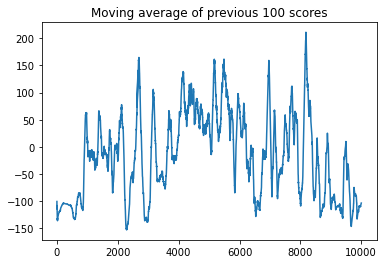

In [6]:
#     manage_memory()
env = gym.make('BipedalWalker-v3')
agent = Agent(inputShape=env.observation_space.shape, env=env,actionsNumber=env.action_space.shape[0], alpha=0.0001, beta=0.001)
gamesNumber = 10000

plotFile = 'plot_ddpg.png'

bestScore = env.reward_range[0]
historyScores = []
checkpoint = False

if checkpoint:
    agent.load()
    evaluate = True
    
else:
    evaluate = False

for i in range(gamesNumber):
    observation = env.reset()
    done = False
    score = 0
    while not done:
        action = agent.chooseAction(observation, evaluate)
        nextObservation, reward, done, info = env.step(action)
        score += reward
        agent.transition(observation, action, reward, nextObservation, done)
        if not checkpoint:
            agent.learn()
        observation = nextObservation

    historyScores.append(score)
    avgScore = np.mean(historyScores[-100:])

    if avgScore > bestScore:
        bestScore = avgScore
        if not checkpoint:
            agent.save()

    print('episode {} score {:.1f} avg score {:.1f}'.
          format(i, score, avgScore))

if not checkpoint:
    x = [i+1 for i in range(gamesNumber)]
    plot(x, historyScores, plotFile)

C:\Users\tyw47\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


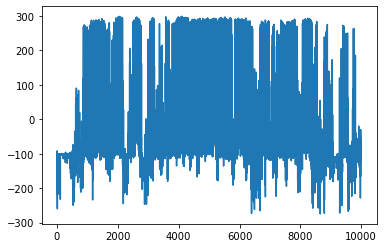

In [7]:
plt.plot(historyScores)
plt.show()

In [6]:
env = gym.make('BipedalWalker-v3')
agent = Agent(inputShape=env.observation_space.shape, env=env,actionsNumber=env.action_space.shape[0], alpha=0.0001, beta=0.001)
checkpoint = True

if checkpoint:
    agent.load()
    evaluate = True
    
else:
    evaluate = False

for i in range(1):
    observation = env.reset()
    done = False
    score = 0
    while not done:
        env.render()
        action = agent.chooseAction(observation, evaluate)
        nextObservation, reward, done, info = env.step(action)
        score += reward
        agent.transition(observation, action, reward, nextObservation, done)
        if not checkpoint:
            agent.learn()
        observation = nextObservation
    env.close()


load models


# Random Agent for BipedalWalker

episode 0 score -84.0 avg score -84.0
episode 1 score -82.6 avg score -83.3
episode 2 score -99.8 avg score -88.8
episode 3 score -85.6 avg score -88.0
episode 4 score -82.0 avg score -86.8
episode 5 score -101.5 avg score -89.3
episode 6 score -106.7 avg score -91.7
episode 7 score -106.0 avg score -93.5
episode 8 score -81.0 avg score -92.1
episode 9 score -116.3 avg score -94.6
episode 10 score -76.3 avg score -92.9
episode 11 score -78.3 avg score -91.7
episode 12 score -98.7 avg score -92.2
episode 13 score -100.1 avg score -92.8
episode 14 score -102.8 avg score -93.5
episode 15 score -77.8 avg score -92.5
episode 16 score -104.4 avg score -93.2
episode 17 score -112.7 avg score -94.3
episode 18 score -119.0 avg score -95.6
episode 19 score -119.9 avg score -96.8
episode 20 score -114.4 avg score -97.6
episode 21 score -99.9 avg score -97.7
episode 22 score -80.2 avg score -97.0
episode 23 score -101.2 avg score -97.1
episode 24 score -79.5 avg score -96.4
episode 25 score -98.1 

episode 206 score -90.5 avg score -98.3
episode 207 score -102.7 avg score -98.3
episode 208 score -103.6 avg score -98.3
episode 209 score -104.7 avg score -98.3
episode 210 score -105.3 avg score -98.4
episode 211 score -94.6 avg score -98.2
episode 212 score -118.6 avg score -98.2
episode 213 score -104.3 avg score -98.2
episode 214 score -100.3 avg score -98.2
episode 215 score -101.4 avg score -98.3
episode 216 score -98.6 avg score -98.4
episode 217 score -88.8 avg score -98.2
episode 218 score -128.3 avg score -98.3
episode 219 score -103.5 avg score -98.1
episode 220 score -112.3 avg score -98.4
episode 221 score -77.0 avg score -98.0
episode 222 score -100.2 avg score -98.0
episode 223 score -112.5 avg score -98.4
episode 224 score -81.7 avg score -98.3
episode 225 score -95.2 avg score -98.4
episode 226 score -106.4 avg score -98.3
episode 227 score -100.1 avg score -98.3
episode 228 score -101.0 avg score -98.5
episode 229 score -87.7 avg score -98.6
episode 230 score -114.1

episode 409 score -78.5 avg score -99.3
episode 410 score -115.6 avg score -99.4
episode 411 score -101.3 avg score -99.6
episode 412 score -97.8 avg score -99.8
episode 413 score -99.4 avg score -100.0
episode 414 score -105.9 avg score -99.8
episode 415 score -87.3 avg score -99.8
episode 416 score -81.5 avg score -99.8
episode 417 score -76.5 avg score -99.3
episode 418 score -111.4 avg score -99.2
episode 419 score -98.9 avg score -99.1
episode 420 score -83.4 avg score -98.9
episode 421 score -124.4 avg score -99.0
episode 422 score -101.7 avg score -99.1
episode 423 score -118.4 avg score -99.1
episode 424 score -114.4 avg score -99.2
episode 425 score -82.0 avg score -99.2
episode 426 score -113.7 avg score -99.4
episode 427 score -98.7 avg score -99.3
episode 428 score -90.3 avg score -99.2
episode 429 score -114.9 avg score -99.5
episode 430 score -79.9 avg score -99.4
episode 431 score -113.1 avg score -99.6
episode 432 score -111.3 avg score -99.7
episode 433 score -99.6 avg

episode 610 score -104.3 avg score -98.9
episode 611 score -104.6 avg score -98.9
episode 612 score -86.1 avg score -98.5
episode 613 score -79.3 avg score -98.4
episode 614 score -102.1 avg score -98.6
episode 615 score -90.3 avg score -98.5
episode 616 score -73.7 avg score -98.3
episode 617 score -105.0 avg score -98.3
episode 618 score -75.0 avg score -98.1
episode 619 score -85.3 avg score -97.9
episode 620 score -111.0 avg score -98.0
episode 621 score -120.9 avg score -98.0
episode 622 score -86.9 avg score -97.7
episode 623 score -111.4 avg score -98.1
episode 624 score -82.0 avg score -97.9
episode 625 score -100.5 avg score -97.7
episode 626 score -122.1 avg score -97.8
episode 627 score -109.7 avg score -97.7
episode 628 score -123.2 avg score -98.1
episode 629 score -80.1 avg score -97.8
episode 630 score -105.1 avg score -98.1
episode 631 score -84.6 avg score -97.9
episode 632 score -77.8 avg score -97.7
episode 633 score -101.9 avg score -97.6
episode 634 score -106.6 av

episode 811 score -86.4 avg score -100.3
episode 812 score -105.0 avg score -100.3
episode 813 score -111.7 avg score -100.7
episode 814 score -115.0 avg score -100.6
episode 815 score -111.4 avg score -100.5
episode 816 score -99.5 avg score -100.5
episode 817 score -101.3 avg score -100.5
episode 818 score -87.0 avg score -100.3
episode 819 score -95.6 avg score -100.3
episode 820 score -100.5 avg score -100.2
episode 821 score -82.6 avg score -99.9
episode 822 score -107.2 avg score -100.2
episode 823 score -84.0 avg score -100.1
episode 824 score -101.8 avg score -100.2
episode 825 score -100.9 avg score -100.2
episode 826 score -76.4 avg score -100.2
episode 827 score -86.4 avg score -100.0
episode 828 score -105.0 avg score -99.9
episode 829 score -75.3 avg score -99.5
episode 830 score -101.0 avg score -99.6
episode 831 score -113.1 avg score -99.5
episode 832 score -98.5 avg score -99.8
episode 833 score -83.9 avg score -99.8
episode 834 score -79.7 avg score -99.6
episode 835 

episode 1010 score -97.9 avg score -99.5
episode 1011 score -102.9 avg score -99.4
episode 1012 score -102.6 avg score -99.4
episode 1013 score -97.6 avg score -99.2
episode 1014 score -112.7 avg score -99.3
episode 1015 score -107.8 avg score -99.5
episode 1016 score -89.8 avg score -99.4
episode 1017 score -81.4 avg score -99.1
episode 1018 score -101.1 avg score -99.0
episode 1019 score -74.4 avg score -98.6
episode 1020 score -97.6 avg score -98.5
episode 1021 score -104.2 avg score -98.4
episode 1022 score -109.5 avg score -98.4
episode 1023 score -117.9 avg score -98.8
episode 1024 score -112.3 avg score -98.9
episode 1025 score -114.4 avg score -99.2
episode 1026 score -87.6 avg score -99.2
episode 1027 score -116.8 avg score -99.5
episode 1028 score -101.4 avg score -99.4
episode 1029 score -84.9 avg score -99.2
episode 1030 score -98.8 avg score -99.2
episode 1031 score -84.1 avg score -99.0
episode 1032 score -115.1 avg score -99.2
episode 1033 score -79.8 avg score -98.9
epi

episode 1210 score -111.1 avg score -98.1
episode 1211 score -106.7 avg score -98.1
episode 1212 score -90.0 avg score -98.0
episode 1213 score -88.0 avg score -97.9
episode 1214 score -90.0 avg score -98.0
episode 1215 score -81.0 avg score -98.0
episode 1216 score -102.4 avg score -98.0
episode 1217 score -100.0 avg score -98.2
episode 1218 score -106.0 avg score -98.2
episode 1219 score -111.2 avg score -98.6
episode 1220 score -116.4 avg score -98.7
episode 1221 score -99.6 avg score -98.7
episode 1222 score -106.7 avg score -98.9
episode 1223 score -81.0 avg score -98.5
episode 1224 score -80.6 avg score -98.6
episode 1225 score -104.3 avg score -98.6
episode 1226 score -100.0 avg score -98.5
episode 1227 score -101.1 avg score -98.5
episode 1228 score -109.2 avg score -98.6
episode 1229 score -102.5 avg score -98.6
episode 1230 score -118.5 avg score -98.8
episode 1231 score -100.2 avg score -98.9
episode 1232 score -99.6 avg score -99.0
episode 1233 score -109.5 avg score -98.9


episode 1405 score -118.5 avg score -98.5
episode 1406 score -106.7 avg score -98.5
episode 1407 score -82.3 avg score -98.5
episode 1408 score -84.7 avg score -98.2
episode 1409 score -118.9 avg score -98.5
episode 1410 score -84.6 avg score -98.2
episode 1411 score -105.9 avg score -98.2
episode 1412 score -98.2 avg score -98.1
episode 1413 score -88.0 avg score -97.9
episode 1414 score -105.4 avg score -97.9
episode 1415 score -85.9 avg score -97.7
episode 1416 score -102.6 avg score -97.5
episode 1417 score -103.2 avg score -97.6
episode 1418 score -78.5 avg score -97.2
episode 1419 score -102.5 avg score -97.1
episode 1420 score -85.1 avg score -96.8
episode 1421 score -80.4 avg score -96.6
episode 1422 score -100.7 avg score -96.5
episode 1423 score -79.8 avg score -96.3
episode 1424 score -101.7 avg score -96.2
episode 1425 score -112.3 avg score -96.2
episode 1426 score -101.8 avg score -96.3
episode 1427 score -84.3 avg score -96.3
episode 1428 score -104.0 avg score -96.4
epi

episode 1600 score -104.3 avg score -100.9
episode 1601 score -75.2 avg score -100.7
episode 1602 score -102.0 avg score -100.7
episode 1603 score -96.9 avg score -100.5
episode 1604 score -81.6 avg score -100.2
episode 1605 score -114.6 avg score -100.5
episode 1606 score -101.5 avg score -100.5
episode 1607 score -102.2 avg score -100.4
episode 1608 score -105.0 avg score -100.6
episode 1609 score -77.0 avg score -100.3
episode 1610 score -125.9 avg score -100.6
episode 1611 score -101.7 avg score -100.6
episode 1612 score -102.7 avg score -100.9
episode 1613 score -113.5 avg score -100.9
episode 1614 score -87.4 avg score -100.8
episode 1615 score -81.4 avg score -100.6
episode 1616 score -100.1 avg score -100.8
episode 1617 score -100.9 avg score -101.0
episode 1618 score -123.9 avg score -101.2
episode 1619 score -76.8 avg score -101.0
episode 1620 score -118.4 avg score -101.2
episode 1621 score -112.5 avg score -101.2
episode 1622 score -120.8 avg score -101.4
episode 1623 score

episode 1795 score -81.6 avg score -100.3
episode 1796 score -101.7 avg score -100.4
episode 1797 score -112.5 avg score -100.4
episode 1798 score -76.2 avg score -100.3
episode 1799 score -102.8 avg score -100.2
episode 1800 score -84.8 avg score -100.2
episode 1801 score -85.7 avg score -99.7
episode 1802 score -84.5 avg score -99.5
episode 1803 score -101.6 avg score -99.7
episode 1804 score -93.6 avg score -99.6
episode 1805 score -116.2 avg score -99.6
episode 1806 score -88.0 avg score -99.4
episode 1807 score -106.6 avg score -99.4
episode 1808 score -85.6 avg score -99.3
episode 1809 score -105.8 avg score -99.6
episode 1810 score -103.9 avg score -99.5
episode 1811 score -84.7 avg score -99.2
episode 1812 score -100.6 avg score -99.4
episode 1813 score -84.7 avg score -99.2
episode 1814 score -78.2 avg score -98.8
episode 1815 score -100.0 avg score -98.6
episode 1816 score -101.5 avg score -98.8
episode 1817 score -97.6 avg score -98.7
episode 1818 score -117.4 avg score -98.

episode 1996 score -75.8 avg score -97.5
episode 1997 score -96.7 avg score -97.6
episode 1998 score -80.5 avg score -97.3
episode 1999 score -86.3 avg score -97.1
episode 2000 score -87.4 avg score -96.9
episode 2001 score -110.4 avg score -97.0
episode 2002 score -107.1 avg score -97.1
episode 2003 score -99.3 avg score -96.9
episode 2004 score -101.2 avg score -96.9
episode 2005 score -116.1 avg score -96.9
episode 2006 score -105.9 avg score -97.1
episode 2007 score -104.1 avg score -97.0
episode 2008 score -83.6 avg score -96.9
episode 2009 score -101.2 avg score -96.9
episode 2010 score -87.7 avg score -96.9
episode 2011 score -86.6 avg score -96.6
episode 2012 score -79.5 avg score -96.3
episode 2013 score -96.2 avg score -96.2
episode 2014 score -119.5 avg score -96.5
episode 2015 score -82.7 avg score -96.2
episode 2016 score -104.3 avg score -96.3
episode 2017 score -99.1 avg score -96.4
episode 2018 score -101.7 avg score -96.6
episode 2019 score -119.7 avg score -97.0
episo

episode 2196 score -102.0 avg score -98.7
episode 2197 score -127.3 avg score -99.3
episode 2198 score -82.2 avg score -99.1
episode 2199 score -83.2 avg score -98.9
episode 2200 score -109.6 avg score -99.2
episode 2201 score -106.9 avg score -99.2
episode 2202 score -80.2 avg score -99.2
episode 2203 score -105.7 avg score -99.2
episode 2204 score -75.3 avg score -98.7
episode 2205 score -83.7 avg score -98.7
episode 2206 score -115.3 avg score -98.8
episode 2207 score -103.6 avg score -98.6
episode 2208 score -98.7 avg score -98.4
episode 2209 score -80.7 avg score -98.4
episode 2210 score -104.4 avg score -98.6
episode 2211 score -106.5 avg score -98.9
episode 2212 score -102.0 avg score -99.0
episode 2213 score -117.3 avg score -99.1
episode 2214 score -101.9 avg score -99.1
episode 2215 score -97.2 avg score -98.9
episode 2216 score -119.0 avg score -99.3
episode 2217 score -111.1 avg score -99.3
episode 2218 score -111.0 avg score -99.4
episode 2219 score -83.8 avg score -99.4
e

episode 2390 score -82.8 avg score -100.2
episode 2391 score -75.5 avg score -100.0
episode 2392 score -101.7 avg score -100.2
episode 2393 score -99.6 avg score -100.1
episode 2394 score -110.9 avg score -100.2
episode 2395 score -120.8 avg score -100.6
episode 2396 score -118.4 avg score -100.9
episode 2397 score -106.5 avg score -101.0
episode 2398 score -101.8 avg score -101.0
episode 2399 score -83.4 avg score -100.8
episode 2400 score -99.1 avg score -100.9
episode 2401 score -92.8 avg score -100.7
episode 2402 score -101.3 avg score -100.5
episode 2403 score -108.8 avg score -100.6
episode 2404 score -101.6 avg score -100.6
episode 2405 score -100.4 avg score -100.8
episode 2406 score -97.8 avg score -100.8
episode 2407 score -99.1 avg score -100.6
episode 2408 score -109.0 avg score -100.5
episode 2409 score -101.2 avg score -100.4
episode 2410 score -96.5 avg score -100.3
episode 2411 score -82.7 avg score -100.0
episode 2412 score -98.5 avg score -99.9
episode 2413 score -97.

episode 2587 score -111.2 avg score -99.6
episode 2588 score -123.0 avg score -99.7
episode 2589 score -96.7 avg score -99.7
episode 2590 score -105.4 avg score -99.6
episode 2591 score -99.0 avg score -99.6
episode 2592 score -66.0 avg score -99.3
episode 2593 score -103.3 avg score -99.5
episode 2594 score -81.5 avg score -99.3
episode 2595 score -81.2 avg score -99.1
episode 2596 score -110.8 avg score -99.1
episode 2597 score -116.8 avg score -99.4
episode 2598 score -117.4 avg score -99.6
episode 2599 score -97.6 avg score -99.7
episode 2600 score -101.3 avg score -99.8
episode 2601 score -100.0 avg score -99.8
episode 2602 score -75.2 avg score -99.8
episode 2603 score -100.1 avg score -100.0
episode 2604 score -103.0 avg score -100.1
episode 2605 score -105.0 avg score -100.4
episode 2606 score -101.8 avg score -100.2
episode 2607 score -81.2 avg score -99.9
episode 2608 score -101.8 avg score -100.2
episode 2609 score -100.5 avg score -100.3
episode 2610 score -99.5 avg score -

episode 2787 score -113.7 avg score -99.3
episode 2788 score -124.8 avg score -99.5
episode 2789 score -77.6 avg score -99.3
episode 2790 score -91.2 avg score -99.1
episode 2791 score -83.8 avg score -99.1
episode 2792 score -106.6 avg score -99.3
episode 2793 score -98.4 avg score -99.4
episode 2794 score -109.0 avg score -99.5
episode 2795 score -77.1 avg score -99.1
episode 2796 score -99.2 avg score -99.1
episode 2797 score -89.4 avg score -99.0
episode 2798 score -99.4 avg score -98.9
episode 2799 score -98.6 avg score -99.1
episode 2800 score -103.1 avg score -99.2
episode 2801 score -100.3 avg score -99.2
episode 2802 score -111.4 avg score -99.3
episode 2803 score -101.0 avg score -99.5
episode 2804 score -97.2 avg score -99.5
episode 2805 score -101.6 avg score -99.5
episode 2806 score -86.3 avg score -99.3
episode 2807 score -102.9 avg score -99.4
episode 2808 score -109.3 avg score -99.5
episode 2809 score -107.4 avg score -99.5
episode 2810 score -114.5 avg score -99.5
epi

episode 2982 score -79.4 avg score -101.0
episode 2983 score -100.3 avg score -101.0
episode 2984 score -102.1 avg score -100.9
episode 2985 score -101.8 avg score -100.9
episode 2986 score -83.4 avg score -100.6
episode 2987 score -115.8 avg score -100.8
episode 2988 score -118.8 avg score -101.2
episode 2989 score -115.5 avg score -101.1
episode 2990 score -78.6 avg score -100.9
episode 2991 score -99.2 avg score -100.9
episode 2992 score -80.3 avg score -100.9
episode 2993 score -106.5 avg score -100.8
episode 2994 score -108.8 avg score -101.0
episode 2995 score -90.9 avg score -101.1
episode 2996 score -81.0 avg score -101.0
episode 2997 score -102.1 avg score -100.9
episode 2998 score -79.2 avg score -100.6
episode 2999 score -103.1 avg score -100.6
episode 3000 score -103.9 avg score -100.9
episode 3001 score -101.1 avg score -100.9
episode 3002 score -87.8 avg score -100.3
episode 3003 score -81.4 avg score -100.2
episode 3004 score -100.6 avg score -100.3
episode 3005 score -1

episode 3178 score -91.7 avg score -99.7
episode 3179 score -100.5 avg score -99.6
episode 3180 score -108.4 avg score -99.6
episode 3181 score -85.6 avg score -99.4
episode 3182 score -83.8 avg score -99.2
episode 3183 score -103.1 avg score -99.2
episode 3184 score -100.5 avg score -99.2
episode 3185 score -112.4 avg score -99.3
episode 3186 score -99.9 avg score -99.3
episode 3187 score -118.4 avg score -99.4
episode 3188 score -102.5 avg score -99.2
episode 3189 score -87.4 avg score -99.0
episode 3190 score -110.8 avg score -99.2
episode 3191 score -79.3 avg score -98.9
episode 3192 score -162.7 avg score -99.5
episode 3193 score -99.0 avg score -99.5
episode 3194 score -103.2 avg score -99.6
episode 3195 score -85.7 avg score -99.7
episode 3196 score -99.3 avg score -99.9
episode 3197 score -87.2 avg score -100.0
episode 3198 score -114.4 avg score -100.0
episode 3199 score -91.2 avg score -99.8
episode 3200 score -109.6 avg score -99.7
episode 3201 score -91.2 avg score -99.7
ep

episode 3374 score -124.3 avg score -100.4
episode 3375 score -74.0 avg score -100.0
episode 3376 score -98.0 avg score -100.2
episode 3377 score -115.2 avg score -100.3
episode 3378 score -79.1 avg score -100.1
episode 3379 score -75.2 avg score -99.7
episode 3380 score -114.1 avg score -99.9
episode 3381 score -98.2 avg score -100.0
episode 3382 score -102.3 avg score -99.9
episode 3383 score -86.2 avg score -99.7
episode 3384 score -86.2 avg score -99.8
episode 3385 score -85.6 avg score -99.3
episode 3386 score -119.9 avg score -99.6
episode 3387 score -98.9 avg score -99.5
episode 3388 score -117.7 avg score -99.5
episode 3389 score -80.5 avg score -99.2
episode 3390 score -103.1 avg score -99.3
episode 3391 score -102.9 avg score -99.5
episode 3392 score -101.1 avg score -99.5
episode 3393 score -85.0 avg score -99.4
episode 3394 score -125.6 avg score -99.6
episode 3395 score -79.8 avg score -99.3
episode 3396 score -77.0 avg score -99.2
episode 3397 score -119.9 avg score -99.3

episode 3572 score -77.1 avg score -99.2
episode 3573 score -114.2 avg score -99.4
episode 3574 score -99.4 avg score -99.6
episode 3575 score -122.3 avg score -99.8
episode 3576 score -81.7 avg score -99.5
episode 3577 score -83.6 avg score -99.1
episode 3578 score -99.7 avg score -99.3
episode 3579 score -112.7 avg score -99.6
episode 3580 score -98.9 avg score -99.6
episode 3581 score -85.2 avg score -99.3
episode 3582 score -121.7 avg score -99.6
episode 3583 score -86.5 avg score -99.4
episode 3584 score -113.1 avg score -99.5
episode 3585 score -112.4 avg score -99.6
episode 3586 score -104.4 avg score -99.6
episode 3587 score -105.2 avg score -99.7
episode 3588 score -110.9 avg score -99.9
episode 3589 score -93.2 avg score -99.9
episode 3590 score -89.5 avg score -99.6
episode 3591 score -103.0 avg score -99.6
episode 3592 score -84.5 avg score -99.6
episode 3593 score -114.7 avg score -99.7
episode 3594 score -89.7 avg score -99.8
episode 3595 score -100.7 avg score -99.8
epis

episode 3772 score -80.4 avg score -99.7
episode 3773 score -83.8 avg score -99.8
episode 3774 score -111.2 avg score -99.8
episode 3775 score -78.5 avg score -99.6
episode 3776 score -102.0 avg score -99.7
episode 3777 score -119.8 avg score -99.8
episode 3778 score -98.7 avg score -99.7
episode 3779 score -91.7 avg score -99.7
episode 3780 score -87.3 avg score -99.5
episode 3781 score -118.4 avg score -99.8
episode 3782 score -86.3 avg score -99.8
episode 3783 score -76.9 avg score -99.4
episode 3784 score -102.1 avg score -99.3
episode 3785 score -89.7 avg score -99.1
episode 3786 score -84.2 avg score -98.8
episode 3787 score -77.9 avg score -98.8
episode 3788 score -113.3 avg score -98.9
episode 3789 score -87.6 avg score -98.8
episode 3790 score -111.6 avg score -98.9
episode 3791 score -81.2 avg score -98.6
episode 3792 score -79.6 avg score -98.3
episode 3793 score -97.9 avg score -98.1
episode 3794 score -89.0 avg score -98.2
episode 3795 score -123.6 avg score -98.2
episode 

episode 3970 score -127.8 avg score -100.4
episode 3971 score -98.9 avg score -100.4
episode 3972 score -101.0 avg score -100.2
episode 3973 score -114.9 avg score -100.5
episode 3974 score -100.7 avg score -100.5
episode 3975 score -109.6 avg score -100.6
episode 3976 score -76.9 avg score -100.3
episode 3977 score -96.2 avg score -100.1
episode 3978 score -112.0 avg score -100.4
episode 3979 score -105.3 avg score -100.6
episode 3980 score -76.5 avg score -100.1
episode 3981 score -76.7 avg score -99.8
episode 3982 score -108.7 avg score -99.9
episode 3983 score -102.0 avg score -99.7
episode 3984 score -99.5 avg score -99.7
episode 3985 score -79.9 avg score -99.5
episode 3986 score -103.0 avg score -99.8
episode 3987 score -120.3 avg score -100.1
episode 3988 score -76.4 avg score -99.8
episode 3989 score -101.9 avg score -100.1
episode 3990 score -90.2 avg score -100.0
episode 3991 score -85.4 avg score -99.8
episode 3992 score -100.3 avg score -100.0
episode 3993 score -80.9 avg 

episode 4166 score -84.4 avg score -100.8
episode 4167 score -82.4 avg score -100.7
episode 4168 score -122.4 avg score -101.1
episode 4169 score -116.5 avg score -101.2
episode 4170 score -98.3 avg score -101.2
episode 4171 score -76.4 avg score -101.0
episode 4172 score -98.9 avg score -100.8
episode 4173 score -110.8 avg score -100.9
episode 4174 score -71.1 avg score -100.4
episode 4175 score -73.1 avg score -100.2
episode 4176 score -99.4 avg score -100.2
episode 4177 score -102.6 avg score -100.2
episode 4178 score -113.3 avg score -100.2
episode 4179 score -111.1 avg score -100.2
episode 4180 score -115.5 avg score -100.6
episode 4181 score -99.8 avg score -100.4
episode 4182 score -108.3 avg score -100.5
episode 4183 score -112.8 avg score -100.8
episode 4184 score -94.6 avg score -100.7
episode 4185 score -100.6 avg score -100.7
episode 4186 score -85.5 avg score -100.8
episode 4187 score -114.7 avg score -100.9
episode 4188 score -108.8 avg score -100.9
episode 4189 score -10

episode 4363 score -116.2 avg score -100.2
episode 4364 score -99.1 avg score -100.4
episode 4365 score -94.7 avg score -100.3
episode 4366 score -99.5 avg score -100.4
episode 4367 score -102.2 avg score -100.3
episode 4368 score -101.9 avg score -100.5
episode 4369 score -119.6 avg score -101.0
episode 4370 score -69.1 avg score -100.9
episode 4371 score -73.4 avg score -100.6
episode 4372 score -79.4 avg score -100.5
episode 4373 score -105.4 avg score -100.5
episode 4374 score -70.8 avg score -100.2
episode 4375 score -98.7 avg score -100.3
episode 4376 score -121.5 avg score -100.3
episode 4377 score -100.4 avg score -100.2
episode 4378 score -111.0 avg score -100.5
episode 4379 score -119.8 avg score -100.7
episode 4380 score -78.0 avg score -100.4
episode 4381 score -84.1 avg score -100.2
episode 4382 score -106.2 avg score -100.3
episode 4383 score -103.5 avg score -100.5
episode 4384 score -81.5 avg score -100.3
episode 4385 score -81.1 avg score -100.1
episode 4386 score -98.

episode 4561 score -89.8 avg score -100.3
episode 4562 score -121.6 avg score -100.3
episode 4563 score -118.1 avg score -100.4
episode 4564 score -97.0 avg score -100.4
episode 4565 score -99.8 avg score -100.6
episode 4566 score -107.3 avg score -100.4
episode 4567 score -100.1 avg score -100.4
episode 4568 score -100.0 avg score -100.3
episode 4569 score -101.4 avg score -100.4
episode 4570 score -122.7 avg score -100.8
episode 4571 score -86.5 avg score -100.6
episode 4572 score -105.4 avg score -100.9
episode 4573 score -101.7 avg score -100.9
episode 4574 score -100.2 avg score -100.9
episode 4575 score -103.7 avg score -100.8
episode 4576 score -103.5 avg score -100.8
episode 4577 score -99.1 avg score -101.0
episode 4578 score -76.2 avg score -100.9
episode 4579 score -107.2 avg score -101.0
episode 4580 score -107.3 avg score -101.0
episode 4581 score -82.2 avg score -101.1
episode 4582 score -102.8 avg score -101.2
episode 4583 score -111.9 avg score -101.1
episode 4584 score

episode 4758 score -100.7 avg score -99.3
episode 4759 score -81.6 avg score -99.3
episode 4760 score -117.5 avg score -99.5
episode 4761 score -83.2 avg score -99.3
episode 4762 score -99.8 avg score -99.2
episode 4763 score -103.2 avg score -99.1
episode 4764 score -101.6 avg score -98.9
episode 4765 score -110.7 avg score -99.3
episode 4766 score -116.7 avg score -99.4
episode 4767 score -81.7 avg score -99.2
episode 4768 score -98.5 avg score -99.1
episode 4769 score -80.2 avg score -98.7
episode 4770 score -78.8 avg score -98.7
episode 4771 score -108.7 avg score -98.7
episode 4772 score -121.9 avg score -99.0
episode 4773 score -90.8 avg score -98.7
episode 4774 score -118.6 avg score -98.8
episode 4775 score -97.5 avg score -98.7
episode 4776 score -98.2 avg score -98.7
episode 4777 score -82.5 avg score -98.5
episode 4778 score -100.4 avg score -98.6
episode 4779 score -101.6 avg score -98.6
episode 4780 score -104.4 avg score -98.8
episode 4781 score -114.8 avg score -98.9
epi

episode 4956 score -103.0 avg score -98.7
episode 4957 score -108.6 avg score -98.9
episode 4958 score -88.0 avg score -98.7
episode 4959 score -83.1 avg score -98.8
episode 4960 score -119.5 avg score -99.2
episode 4961 score -106.4 avg score -99.4
episode 4962 score -114.8 avg score -99.6
episode 4963 score -78.2 avg score -99.2
episode 4964 score -105.6 avg score -99.2
episode 4965 score -82.3 avg score -99.0
episode 4966 score -83.8 avg score -98.7
episode 4967 score -112.5 avg score -99.1
episode 4968 score -120.1 avg score -99.3
episode 4969 score -120.0 avg score -99.7
episode 4970 score -80.8 avg score -99.5
episode 4971 score -115.9 avg score -99.6
episode 4972 score -77.8 avg score -99.4
episode 4973 score -98.7 avg score -99.3
episode 4974 score -101.9 avg score -99.1
episode 4975 score -105.2 avg score -99.1
episode 4976 score -83.0 avg score -98.7
episode 4977 score -88.9 avg score -98.6
episode 4978 score -100.8 avg score -98.7
episode 4979 score -119.8 avg score -99.1
ep

episode 5153 score -83.4 avg score -98.2
episode 5154 score -80.2 avg score -98.0
episode 5155 score -102.7 avg score -98.2
episode 5156 score -113.8 avg score -98.3
episode 5157 score -100.9 avg score -98.6
episode 5158 score -108.0 avg score -98.6
episode 5159 score -104.9 avg score -98.5
episode 5160 score -113.3 avg score -98.6
episode 5161 score -104.0 avg score -98.6
episode 5162 score -82.4 avg score -98.4
episode 5163 score -107.5 avg score -98.3
episode 5164 score -69.4 avg score -97.9
episode 5165 score -98.9 avg score -97.8
episode 5166 score -105.4 avg score -98.0
episode 5167 score -106.6 avg score -98.1
episode 5168 score -101.6 avg score -98.4
episode 5169 score -118.8 avg score -98.5
episode 5170 score -78.8 avg score -98.2
episode 5171 score -83.6 avg score -97.9
episode 5172 score -110.1 avg score -98.1
episode 5173 score -106.1 avg score -98.2
episode 5174 score -123.5 avg score -98.6
episode 5175 score -100.4 avg score -98.4
episode 5176 score -102.2 avg score -98.2

episode 5348 score -114.3 avg score -99.7
episode 5349 score -104.8 avg score -99.7
episode 5350 score -102.0 avg score -99.7
episode 5351 score -114.8 avg score -99.9
episode 5352 score -100.3 avg score -99.9
episode 5353 score -125.3 avg score -99.9
episode 5354 score -77.8 avg score -99.8
episode 5355 score -83.9 avg score -99.7
episode 5356 score -77.8 avg score -99.7
episode 5357 score -108.1 avg score -99.9
episode 5358 score -123.7 avg score -100.4
episode 5359 score -104.2 avg score -100.5
episode 5360 score -109.3 avg score -100.9
episode 5361 score -101.5 avg score -100.8
episode 5362 score -79.0 avg score -100.4
episode 5363 score -107.9 avg score -100.6
episode 5364 score -108.7 avg score -100.9
episode 5365 score -101.0 avg score -100.9
episode 5366 score -121.3 avg score -101.0
episode 5367 score -84.1 avg score -100.8
episode 5368 score -115.1 avg score -101.1
episode 5369 score -80.0 avg score -100.9
episode 5370 score -102.6 avg score -101.1
episode 5371 score -100.1 a

episode 5545 score -83.4 avg score -98.7
episode 5546 score -76.6 avg score -98.6
episode 5547 score -99.5 avg score -98.6
episode 5548 score -101.0 avg score -98.6
episode 5549 score -107.8 avg score -98.7
episode 5550 score -112.1 avg score -98.6
episode 5551 score -115.6 avg score -99.0
episode 5552 score -107.5 avg score -99.2
episode 5553 score -102.5 avg score -99.0
episode 5554 score -121.7 avg score -99.2
episode 5555 score -79.1 avg score -99.0
episode 5556 score -102.3 avg score -99.0
episode 5557 score -110.2 avg score -99.0
episode 5558 score -103.1 avg score -98.9
episode 5559 score -103.8 avg score -98.9
episode 5560 score -83.5 avg score -98.7
episode 5561 score -101.9 avg score -98.9
episode 5562 score -100.5 avg score -98.8
episode 5563 score -102.5 avg score -98.9
episode 5564 score -102.7 avg score -99.2
episode 5565 score -109.5 avg score -99.1
episode 5566 score -111.2 avg score -99.1
episode 5567 score -100.9 avg score -98.9
episode 5568 score -103.5 avg score -98

episode 5743 score -120.1 avg score -99.6
episode 5744 score -117.9 avg score -100.0
episode 5745 score -104.1 avg score -100.2
episode 5746 score -116.4 avg score -100.2
episode 5747 score -105.0 avg score -100.3
episode 5748 score -120.4 avg score -100.4
episode 5749 score -103.2 avg score -100.6
episode 5750 score -101.3 avg score -100.8
episode 5751 score -114.4 avg score -100.9
episode 5752 score -106.5 avg score -101.0
episode 5753 score -98.9 avg score -100.9
episode 5754 score -116.6 avg score -101.0
episode 5755 score -101.8 avg score -101.0
episode 5756 score -99.3 avg score -101.2
episode 5757 score -72.0 avg score -100.9
episode 5758 score -116.7 avg score -101.0
episode 5759 score -89.2 avg score -100.8
episode 5760 score -117.7 avg score -100.9
episode 5761 score -111.3 avg score -101.1
episode 5762 score -114.5 avg score -101.2
episode 5763 score -100.0 avg score -101.5
episode 5764 score -103.4 avg score -101.3
episode 5765 score -102.1 avg score -101.2
episode 5766 sco

episode 5938 score -112.3 avg score -101.9
episode 5939 score -101.8 avg score -101.8
episode 5940 score -102.3 avg score -102.0
episode 5941 score -108.3 avg score -102.1
episode 5942 score -116.6 avg score -102.3
episode 5943 score -95.6 avg score -102.2
episode 5944 score -105.4 avg score -102.2
episode 5945 score -100.2 avg score -102.2
episode 5946 score -99.4 avg score -102.3
episode 5947 score -102.5 avg score -102.5
episode 5948 score -96.2 avg score -102.6
episode 5949 score -101.4 avg score -102.6
episode 5950 score -97.4 avg score -102.3
episode 5951 score -86.4 avg score -102.1
episode 5952 score -113.9 avg score -101.9
episode 5953 score -78.3 avg score -101.5
episode 5954 score -80.7 avg score -101.1
episode 5955 score -101.0 avg score -101.0
episode 5956 score -77.4 avg score -100.8
episode 5957 score -98.7 avg score -101.0
episode 5958 score -119.2 avg score -101.2
episode 5959 score -111.1 avg score -101.3
episode 5960 score -100.1 avg score -101.3
episode 5961 score -

episode 6135 score -81.1 avg score -100.4
episode 6136 score -99.8 avg score -100.3
episode 6137 score -101.7 avg score -100.3
episode 6138 score -80.7 avg score -100.2
episode 6139 score -96.6 avg score -100.2
episode 6140 score -75.5 avg score -99.9
episode 6141 score -104.2 avg score -99.9
episode 6142 score -83.9 avg score -99.6
episode 6143 score -88.4 avg score -99.5
episode 6144 score -98.6 avg score -99.3
episode 6145 score -92.6 avg score -99.3
episode 6146 score -81.1 avg score -98.9
episode 6147 score -94.3 avg score -98.8
episode 6148 score -94.6 avg score -98.7
episode 6149 score -76.6 avg score -98.3
episode 6150 score -91.1 avg score -98.2
episode 6151 score -122.7 avg score -98.4
episode 6152 score -114.7 avg score -98.6
episode 6153 score -90.0 avg score -98.3
episode 6154 score -106.3 avg score -98.2
episode 6155 score -116.5 avg score -98.3
episode 6156 score -85.1 avg score -98.1
episode 6157 score -106.0 avg score -97.9
episode 6158 score -118.6 avg score -98.0
epi

episode 6334 score -81.9 avg score -99.0
episode 6335 score -121.7 avg score -99.2
episode 6336 score -107.0 avg score -99.2
episode 6337 score -106.3 avg score -99.3
episode 6338 score -106.7 avg score -99.4
episode 6339 score -87.9 avg score -99.2
episode 6340 score -105.9 avg score -99.3
episode 6341 score -100.2 avg score -99.3
episode 6342 score -103.0 avg score -99.4
episode 6343 score -104.1 avg score -99.5
episode 6344 score -114.1 avg score -99.7
episode 6345 score -105.0 avg score -99.9
episode 6346 score -101.3 avg score -99.9
episode 6347 score -98.3 avg score -99.9
episode 6348 score -112.3 avg score -100.0
episode 6349 score -111.9 avg score -100.0
episode 6350 score -107.0 avg score -100.1
episode 6351 score -105.9 avg score -100.2
episode 6352 score -84.9 avg score -100.0
episode 6353 score -113.3 avg score -100.0
episode 6354 score -102.9 avg score -100.0
episode 6355 score -103.0 avg score -100.1
episode 6356 score -77.1 avg score -99.7
episode 6357 score -104.6 avg s

episode 6530 score -83.4 avg score -98.2
episode 6531 score -75.1 avg score -97.8
episode 6532 score -80.0 avg score -97.6
episode 6533 score -100.5 avg score -97.8
episode 6534 score -119.7 avg score -97.8
episode 6535 score -101.4 avg score -97.9
episode 6536 score -80.6 avg score -97.6
episode 6537 score -111.5 avg score -97.9
episode 6538 score -82.3 avg score -97.7
episode 6539 score -120.3 avg score -98.0
episode 6540 score -77.3 avg score -97.6
episode 6541 score -109.3 avg score -97.8
episode 6542 score -81.6 avg score -97.6
episode 6543 score -84.1 avg score -97.7
episode 6544 score -118.6 avg score -97.8
episode 6545 score -105.3 avg score -97.8
episode 6546 score -103.3 avg score -98.1
episode 6547 score -100.4 avg score -97.9
episode 6548 score -98.6 avg score -98.0
episode 6549 score -102.1 avg score -98.0
episode 6550 score -103.0 avg score -98.3
episode 6551 score -79.1 avg score -97.9
episode 6552 score -113.6 avg score -98.1
episode 6553 score -84.6 avg score -98.0
epi

episode 6726 score -86.1 avg score -98.8
episode 6727 score -78.1 avg score -98.6
episode 6728 score -79.3 avg score -98.1
episode 6729 score -122.7 avg score -98.3
episode 6730 score -96.7 avg score -98.1
episode 6731 score -77.3 avg score -97.7
episode 6732 score -90.3 avg score -97.5
episode 6733 score -100.3 avg score -97.4
episode 6734 score -102.1 avg score -97.6
episode 6735 score -119.0 avg score -98.1
episode 6736 score -118.4 avg score -98.4
episode 6737 score -119.2 avg score -98.7
episode 6738 score -99.8 avg score -98.4
episode 6739 score -108.7 avg score -98.5
episode 6740 score -81.9 avg score -98.3
episode 6741 score -84.4 avg score -98.3
episode 6742 score -124.5 avg score -98.7
episode 6743 score -101.0 avg score -98.6
episode 6744 score -89.5 avg score -98.4
episode 6745 score -77.6 avg score -98.1
episode 6746 score -72.8 avg score -97.8
episode 6747 score -112.0 avg score -97.8
episode 6748 score -120.2 avg score -97.9
episode 6749 score -98.3 avg score -98.1
episo

episode 6920 score -99.5 avg score -102.1
episode 6921 score -116.0 avg score -102.2
episode 6922 score -116.9 avg score -101.7
episode 6923 score -104.9 avg score -101.6
episode 6924 score -119.8 avg score -101.7
episode 6925 score -100.7 avg score -101.7
episode 6926 score -98.7 avg score -101.7
episode 6927 score -112.3 avg score -101.8
episode 6928 score -117.1 avg score -101.8
episode 6929 score -99.4 avg score -101.7
episode 6930 score -109.3 avg score -102.0
episode 6931 score -82.9 avg score -101.7
episode 6932 score -109.1 avg score -101.8
episode 6933 score -98.8 avg score -101.9
episode 6934 score -101.8 avg score -101.9
episode 6935 score -99.5 avg score -102.0
episode 6936 score -111.1 avg score -102.1
episode 6937 score -106.3 avg score -102.0
episode 6938 score -119.6 avg score -102.1
episode 6939 score -101.5 avg score -102.2
episode 6940 score -100.6 avg score -102.4
episode 6941 score -120.0 avg score -102.7
episode 6942 score -94.2 avg score -102.7
episode 6943 score

episode 7115 score -87.1 avg score -97.7
episode 7116 score -120.3 avg score -98.1
episode 7117 score -115.5 avg score -98.4
episode 7118 score -118.8 avg score -98.7
episode 7119 score -77.3 avg score -98.4
episode 7120 score -116.0 avg score -98.8
episode 7121 score -114.9 avg score -99.1
episode 7122 score -79.0 avg score -98.8
episode 7123 score -100.4 avg score -98.8
episode 7124 score -104.1 avg score -98.6
episode 7125 score -125.9 avg score -98.9
episode 7126 score -99.1 avg score -98.8
episode 7127 score -105.0 avg score -98.8
episode 7128 score -82.8 avg score -98.8
episode 7129 score -100.7 avg score -99.0
episode 7130 score -78.1 avg score -98.7
episode 7131 score -82.5 avg score -98.7
episode 7132 score -106.1 avg score -98.8
episode 7133 score -100.1 avg score -99.1
episode 7134 score -98.2 avg score -99.2
episode 7135 score -112.1 avg score -99.5
episode 7136 score -82.0 avg score -99.4
episode 7137 score -80.1 avg score -99.2
episode 7138 score -84.1 avg score -99.0
epi

episode 7311 score -99.8 avg score -99.9
episode 7312 score -122.3 avg score -100.2
episode 7313 score -100.0 avg score -100.2
episode 7314 score -118.7 avg score -100.7
episode 7315 score -86.0 avg score -100.5
episode 7316 score -83.0 avg score -100.3
episode 7317 score -84.1 avg score -100.4
episode 7318 score -107.0 avg score -100.3
episode 7319 score -118.1 avg score -100.4
episode 7320 score -106.7 avg score -100.6
episode 7321 score -103.7 avg score -100.5
episode 7322 score -99.8 avg score -100.7
episode 7323 score -96.9 avg score -100.7
episode 7324 score -105.6 avg score -100.8
episode 7325 score -104.3 avg score -100.8
episode 7326 score -100.9 avg score -100.6
episode 7327 score -86.5 avg score -100.4
episode 7328 score -114.0 avg score -100.5
episode 7329 score -100.0 avg score -100.4
episode 7330 score -113.0 avg score -100.4
episode 7331 score -100.2 avg score -100.4
episode 7332 score -114.1 avg score -100.7
episode 7333 score -80.5 avg score -100.7
episode 7334 score -

episode 7507 score -118.0 avg score -100.4
episode 7508 score -123.3 avg score -100.6
episode 7509 score -116.0 avg score -100.9
episode 7510 score -87.1 avg score -101.0
episode 7511 score -87.5 avg score -100.8
episode 7512 score -113.4 avg score -100.8
episode 7513 score -113.9 avg score -100.7
episode 7514 score -112.9 avg score -100.6
episode 7515 score -107.2 avg score -100.7
episode 7516 score -78.1 avg score -100.5
episode 7517 score -75.8 avg score -100.2
episode 7518 score -114.9 avg score -100.3
episode 7519 score -87.0 avg score -100.0
episode 7520 score -105.1 avg score -99.9
episode 7521 score -101.2 avg score -99.9
episode 7522 score -98.3 avg score -100.2
episode 7523 score -99.6 avg score -100.1
episode 7524 score -78.7 avg score -99.9
episode 7525 score -112.5 avg score -100.0
episode 7526 score -112.3 avg score -100.1
episode 7527 score -115.8 avg score -100.2
episode 7528 score -103.8 avg score -100.2
episode 7529 score -87.5 avg score -100.0
episode 7530 score -81.

episode 7704 score -116.2 avg score -99.9
episode 7705 score -85.4 avg score -99.6
episode 7706 score -124.6 avg score -99.8
episode 7707 score -84.9 avg score -99.9
episode 7708 score -85.4 avg score -99.8
episode 7709 score -100.0 avg score -99.7
episode 7710 score -101.5 avg score -100.0
episode 7711 score -101.7 avg score -100.1
episode 7712 score -105.3 avg score -100.2
episode 7713 score -110.2 avg score -100.2
episode 7714 score -102.5 avg score -100.2
episode 7715 score -84.3 avg score -99.8
episode 7716 score -84.5 avg score -99.5
episode 7717 score -100.8 avg score -99.8
episode 7718 score -115.7 avg score -99.9
episode 7719 score -81.7 avg score -99.6
episode 7720 score -82.6 avg score -99.5
episode 7721 score -99.8 avg score -99.5
episode 7722 score -126.6 avg score -99.8
episode 7723 score -106.3 avg score -99.7
episode 7724 score -96.7 avg score -99.7
episode 7725 score -100.2 avg score -99.6
episode 7726 score -103.6 avg score -99.6
episode 7727 score -80.1 avg score -99

episode 7901 score -78.4 avg score -99.0
episode 7902 score -99.5 avg score -98.9
episode 7903 score -105.3 avg score -99.0
episode 7904 score -101.2 avg score -99.0
episode 7905 score -91.6 avg score -98.9
episode 7906 score -88.2 avg score -99.0
episode 7907 score -80.8 avg score -99.0
episode 7908 score -96.8 avg score -99.0
episode 7909 score -98.3 avg score -98.9
episode 7910 score -100.5 avg score -99.0
episode 7911 score -100.7 avg score -98.8
episode 7912 score -113.6 avg score -98.9
episode 7913 score -79.0 avg score -98.9
episode 7914 score -102.5 avg score -98.9
episode 7915 score -101.5 avg score -99.1
episode 7916 score -87.2 avg score -99.2
episode 7917 score -98.6 avg score -99.2
episode 7918 score -102.9 avg score -99.1
episode 7919 score -100.9 avg score -99.3
episode 7920 score -101.5 avg score -99.4
episode 7921 score -99.9 avg score -99.3
episode 7922 score -123.6 avg score -99.4
episode 7923 score -102.8 avg score -99.3
episode 7924 score -105.5 avg score -99.5
epi

episode 8100 score -106.9 avg score -102.4
episode 8101 score -82.5 avg score -102.1
episode 8102 score -102.3 avg score -102.2
episode 8103 score -85.1 avg score -102.3
episode 8104 score -109.3 avg score -102.2
episode 8105 score -82.2 avg score -102.0
episode 8106 score -99.1 avg score -101.9
episode 8107 score -86.5 avg score -101.6
episode 8108 score -109.4 avg score -101.6
episode 8109 score -101.7 avg score -101.4
episode 8110 score -99.7 avg score -101.4
episode 8111 score -80.1 avg score -101.2
episode 8112 score -78.5 avg score -100.7
episode 8113 score -85.7 avg score -100.6
episode 8114 score -109.5 avg score -100.5
episode 8115 score -85.3 avg score -100.3
episode 8116 score -77.9 avg score -100.1
episode 8117 score -85.0 avg score -99.8
episode 8118 score -89.8 avg score -99.5
episode 8119 score -79.6 avg score -99.4
episode 8120 score -82.0 avg score -99.5
episode 8121 score -83.9 avg score -99.2
episode 8122 score -104.1 avg score -99.2
episode 8123 score -81.3 avg scor

episode 8297 score -81.1 avg score -102.2
episode 8298 score -100.0 avg score -102.2
episode 8299 score -92.2 avg score -102.1
episode 8300 score -108.7 avg score -102.2
episode 8301 score -114.9 avg score -102.3
episode 8302 score -72.9 avg score -102.2
episode 8303 score -100.1 avg score -102.1
episode 8304 score -91.4 avg score -101.8
episode 8305 score -84.5 avg score -101.5
episode 8306 score -124.9 avg score -101.7
episode 8307 score -100.6 avg score -101.8
episode 8308 score -101.4 avg score -101.7
episode 8309 score -105.4 avg score -101.8
episode 8310 score -113.6 avg score -101.9
episode 8311 score -109.7 avg score -101.9
episode 8312 score -82.6 avg score -101.7
episode 8313 score -104.3 avg score -101.6
episode 8314 score -103.4 avg score -101.6
episode 8315 score -80.6 avg score -101.4
episode 8316 score -107.7 avg score -101.6
episode 8317 score -100.6 avg score -101.6
episode 8318 score -118.8 avg score -101.8
episode 8319 score -110.9 avg score -101.7
episode 8320 score

episode 8490 score -116.8 avg score -103.3
episode 8491 score -106.1 avg score -103.2
episode 8492 score -100.7 avg score -103.0
episode 8493 score -141.2 avg score -103.4
episode 8494 score -103.2 avg score -103.4
episode 8495 score -80.4 avg score -103.4
episode 8496 score -84.6 avg score -103.1
episode 8497 score -101.9 avg score -103.0
episode 8498 score -78.4 avg score -102.7
episode 8499 score -100.1 avg score -102.6
episode 8500 score -112.6 avg score -102.7
episode 8501 score -79.0 avg score -102.4
episode 8502 score -72.7 avg score -102.1
episode 8503 score -104.5 avg score -102.0
episode 8504 score -116.7 avg score -102.1
episode 8505 score -102.6 avg score -102.2
episode 8506 score -105.7 avg score -102.3
episode 8507 score -75.9 avg score -101.9
episode 8508 score -104.4 avg score -102.0
episode 8509 score -119.8 avg score -102.2
episode 8510 score -79.5 avg score -102.0
episode 8511 score -85.0 avg score -101.9
episode 8512 score -102.4 avg score -101.9
episode 8513 score 

episode 8688 score -123.0 avg score -100.1
episode 8689 score -114.1 avg score -100.4
episode 8690 score -103.5 avg score -100.5
episode 8691 score -80.2 avg score -100.5
episode 8692 score -102.1 avg score -100.8
episode 8693 score -107.3 avg score -101.1
episode 8694 score -73.1 avg score -100.8
episode 8695 score -83.3 avg score -100.7
episode 8696 score -87.1 avg score -100.4
episode 8697 score -102.8 avg score -100.5
episode 8698 score -84.8 avg score -100.1
episode 8699 score -121.9 avg score -100.4
episode 8700 score -116.3 avg score -100.5
episode 8701 score -110.8 avg score -100.6
episode 8702 score -114.2 avg score -100.7
episode 8703 score -115.1 avg score -100.7
episode 8704 score -91.2 avg score -100.8
episode 8705 score -88.2 avg score -100.9
episode 8706 score -81.2 avg score -100.6
episode 8707 score -90.3 avg score -100.3
episode 8708 score -121.7 avg score -100.4
episode 8709 score -96.4 avg score -100.3
episode 8710 score -89.6 avg score -100.2
episode 8711 score -10

episode 8884 score -84.1 avg score -97.6
episode 8885 score -99.7 avg score -97.4
episode 8886 score -85.6 avg score -97.0
episode 8887 score -103.2 avg score -97.2
episode 8888 score -115.1 avg score -97.1
episode 8889 score -80.9 avg score -96.7
episode 8890 score -108.4 avg score -96.8
episode 8891 score -97.9 avg score -97.0
episode 8892 score -111.5 avg score -97.3
episode 8893 score -75.8 avg score -96.9
episode 8894 score -95.2 avg score -97.1
episode 8895 score -88.5 avg score -97.2
episode 8896 score -101.0 avg score -97.4
episode 8897 score -80.4 avg score -97.1
episode 8898 score -97.9 avg score -97.1
episode 8899 score -107.5 avg score -97.1
episode 8900 score -101.4 avg score -97.3
episode 8901 score -112.6 avg score -97.4
episode 8902 score -113.8 avg score -97.3
episode 8903 score -84.0 avg score -97.2
episode 8904 score -83.0 avg score -97.1
episode 8905 score -103.1 avg score -97.3
episode 8906 score -98.6 avg score -97.3
episode 8907 score -110.6 avg score -97.4
episo

episode 9081 score -82.1 avg score -98.9
episode 9082 score -114.0 avg score -99.0
episode 9083 score -102.5 avg score -98.9
episode 9084 score -87.4 avg score -98.9
episode 9085 score -96.2 avg score -98.9
episode 9086 score -120.5 avg score -98.9
episode 9087 score -100.9 avg score -98.7
episode 9088 score -80.9 avg score -98.4
episode 9089 score -100.1 avg score -98.6
episode 9090 score -105.4 avg score -98.6
episode 9091 score -103.4 avg score -98.4
episode 9092 score -116.0 avg score -98.6
episode 9093 score -85.0 avg score -98.7
episode 9094 score -107.5 avg score -98.6
episode 9095 score -75.9 avg score -98.4
episode 9096 score -98.5 avg score -98.3
episode 9097 score -99.2 avg score -98.5
episode 9098 score -82.8 avg score -98.1
episode 9099 score -98.7 avg score -98.4
episode 9100 score -101.8 avg score -98.5
episode 9101 score -106.0 avg score -98.4
episode 9102 score -93.9 avg score -98.3
episode 9103 score -100.3 avg score -98.1
episode 9104 score -100.0 avg score -98.1
epi

episode 9277 score -87.1 avg score -98.6
episode 9278 score -81.8 avg score -98.6
episode 9279 score -122.1 avg score -98.8
episode 9280 score -102.1 avg score -99.0
episode 9281 score -101.4 avg score -98.8
episode 9282 score -106.5 avg score -98.9
episode 9283 score -88.4 avg score -98.7
episode 9284 score -110.1 avg score -98.8
episode 9285 score -110.2 avg score -98.9
episode 9286 score -101.3 avg score -98.9
episode 9287 score -114.8 avg score -99.0
episode 9288 score -106.6 avg score -99.1
episode 9289 score -105.0 avg score -99.4
episode 9290 score -101.3 avg score -99.4
episode 9291 score -99.2 avg score -99.3
episode 9292 score -81.9 avg score -99.4
episode 9293 score -114.6 avg score -99.5
episode 9294 score -98.9 avg score -99.4
episode 9295 score -112.8 avg score -99.6
episode 9296 score -103.4 avg score -99.6
episode 9297 score -95.7 avg score -99.7
episode 9298 score -94.6 avg score -99.5
episode 9299 score -82.8 avg score -99.3
episode 9300 score -101.6 avg score -99.2
e

episode 9476 score -84.5 avg score -97.4
episode 9477 score -88.5 avg score -97.3
episode 9478 score -84.6 avg score -97.3
episode 9479 score -93.0 avg score -97.4
episode 9480 score -100.6 avg score -97.7
episode 9481 score -77.5 avg score -97.3
episode 9482 score -94.9 avg score -97.4
episode 9483 score -111.7 avg score -97.5
episode 9484 score -80.1 avg score -97.1
episode 9485 score -98.9 avg score -97.0
episode 9486 score -117.2 avg score -97.4
episode 9487 score -99.5 avg score -97.2
episode 9488 score -89.6 avg score -97.2
episode 9489 score -87.3 avg score -97.4
episode 9490 score -86.9 avg score -97.2
episode 9491 score -75.2 avg score -97.2
episode 9492 score -122.6 avg score -97.6
episode 9493 score -99.7 avg score -97.8
episode 9494 score -98.1 avg score -97.6
episode 9495 score -81.7 avg score -97.4
episode 9496 score -100.6 avg score -97.4
episode 9497 score -110.2 avg score -97.4
episode 9498 score -117.1 avg score -97.4
episode 9499 score -92.2 avg score -97.6
episode 9

episode 9672 score -104.2 avg score -99.9
episode 9673 score -87.2 avg score -100.0
episode 9674 score -107.3 avg score -100.1
episode 9675 score -103.4 avg score -100.1
episode 9676 score -81.3 avg score -99.9
episode 9677 score -86.7 avg score -100.0
episode 9678 score -105.6 avg score -100.0
episode 9679 score -119.0 avg score -100.0
episode 9680 score -105.9 avg score -100.1
episode 9681 score -113.3 avg score -100.1
episode 9682 score -97.3 avg score -100.1
episode 9683 score -81.0 avg score -99.7
episode 9684 score -99.9 avg score -99.8
episode 9685 score -110.0 avg score -100.1
episode 9686 score -97.7 avg score -100.1
episode 9687 score -106.5 avg score -100.3
episode 9688 score -90.9 avg score -100.4
episode 9689 score -111.7 avg score -100.5
episode 9690 score -120.4 avg score -100.7
episode 9691 score -103.3 avg score -100.7
episode 9692 score -113.6 avg score -100.8
episode 9693 score -102.5 avg score -100.7
episode 9694 score -103.7 avg score -100.7
episode 9695 score -108

episode 9870 score -102.2 avg score -100.6
episode 9871 score -77.8 avg score -100.3
episode 9872 score -100.4 avg score -100.1
episode 9873 score -83.3 avg score -100.1
episode 9874 score -100.8 avg score -100.2
episode 9875 score -104.9 avg score -100.1
episode 9876 score -107.5 avg score -100.1
episode 9877 score -92.6 avg score -100.2
episode 9878 score -115.0 avg score -100.3
episode 9879 score -100.0 avg score -100.3
episode 9880 score -80.3 avg score -100.1
episode 9881 score -83.1 avg score -99.8
episode 9882 score -105.0 avg score -100.0
episode 9883 score -81.2 avg score -99.8
episode 9884 score -74.9 avg score -99.5
episode 9885 score -112.8 avg score -99.9
episode 9886 score -107.4 avg score -99.8
episode 9887 score -100.8 avg score -99.8
episode 9888 score -106.7 avg score -99.9
episode 9889 score -75.7 avg score -99.6
episode 9890 score -107.3 avg score -99.6
episode 9891 score -101.6 avg score -99.6
episode 9892 score -71.7 avg score -99.2
episode 9893 score -79.1 avg sc

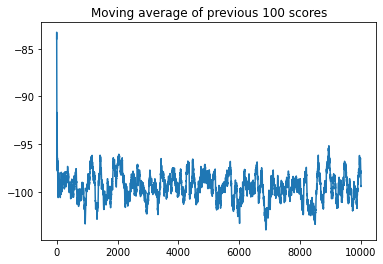

In [7]:
env = gym.make('BipedalWalker-v3')
actionSize = env.action_space.shape[0]

gamesNumber = 10000

plotFile = 'plot_random.png'

bestScore = env.reward_range[0]
historyScores = []

for i in range(gamesNumber):
    env.reset()
    done = False
    score = 0
    while not done:
        action = np.random.uniform(-1.0, 1.0, size=actionSize)
        observation_, reward, done, info = env.step(action)
        score += reward

        if done:
            break

    historyScores.append(score)
    avgScore = np.mean(historyScores[-100:])

    if avgScore > bestScore:
        bestScore = avgScore

    print('episode {} score {:.1f} avg score {:.1f}'.
          format(i, score, avgScore))

x = [i+1 for i in range(gamesNumber)]
plot(x, historyScores, plotFile)

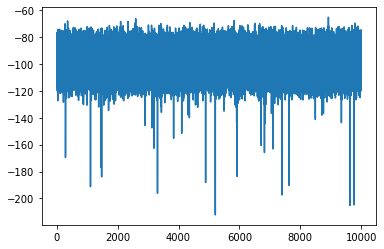

In [8]:
plt.plot(historyScores)
plt.show()

In [9]:
from gym import wrappers

env = gym.make('BipedalWalker-v3')
env = wrappers.Monitor(env, "./gym-results", force=True)
env.reset()

done = False
score = 0
while not done:
    action = np.random.uniform(-1.0, 1.0, size=actionSize)
    observation_, reward, done, info = env.step(action)
    score += reward
    if done:
        env.close()
        break
